# Topic extraction from the GEPRiS dataset and creation of an user-centric visualisation
Author: Tim Korjakow        
Summer term 2018      
Freie Universität Berlin     
Fachgebiet Human-Centered Computing

![Process graph](nlpflowchart.svg)

In [52]:
# general imports
import numpy as np
#import sklearn
import os

# data wrangling
import json
import spacy
spacy.prefer_gpu()
from spacy_langdetect import LanguageDetector
import psycopg2
from multiprocessing import Pool, cpu_count

# document embedding
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_short
import scipy

# topic extraction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF as NonnegativeMatrixFactorization
from gensim.models.coherencemodel import CoherenceModel
import keras
from sklearn.preprocessing import normalize


#clustering
from numpy import triu_indices
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.neighbors import radius_neighbors_graph

# projection into 2d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

# linearization
from lapjv import lapjv
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from numpy.linalg import norm
from sklearn.preprocessing import normalize

# quality metrics of the clustering
from sklearn.metrics import silhouette_samples

# interactivity
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown, FloatSlider
import ipywidgets as widgets
from IPython.display import display, Javascript, HTML
import pickle

#2d plot
from bokeh.io import output_notebook, show, export_png
from bokeh.models import ColumnDataSource, OpenURL, TapTool, LinearAxis, Grid
from bokeh.plotting import figure
from bokeh.models.glyphs import VBar
from bokeh.palettes import d3, brewer, mpl, inferno
from bokeh.layouts import row, column
output_notebook()
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# 3d plot
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True) # for offline mode use

Loading BokehJS ...

## Loading and Cleaning
The first step in every NLP project which works with texts is always the preparation of the input data. In this example the Project dump from GEPRIS is loaded and the project descriptions are extracted. After that the texts get cleaned by removing all non-alphabetic chars and all stopwords from the texts. English texts are getting filtered in oder to make the analysis simpler and more comparable.

In [2]:
with open(os.environ['PG_PASSWORD']) as password_file:
    password = password_file.read().strip()
    conn = psycopg2.connect(dbname="ikon", user="ikonuser", password=password, port=5432, host='Postgres')

class DataLoader(object):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
        self.query = query
        self.data = self.loadFromDB(self.query).fetchall()
            
    def __iter__(self):
        self.pos = 0
        return self
    
    def __next__(self):
        if self.pos >= len(self.data):
            raise StopIteration
        self.pos += 1
        return self.data[self.pos-1]
    
    def  __getitem__(self, pos):
        text, *args = self.data[pos]
        return self.data[self.pos]
    
    def __len__(self):
        return len(self.data)
    
    def __str__(self):
        return str(self.data)
    
    def loadFromDB(self, query):
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor
        
class DataPreprocessor(DataLoader):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
        self.query = query
        self.clean = clean
        self.nlp = spacy.load('de', disable=["ner", "tagger"])
        #self.nlp.add_pipe(self.nlp.create_pipe('sentencizer'))
        self.nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
        self.nlp.Defaults.stop_words |= self.loadGermanStopwords()
        self.nlp.Defaults.stop_words |= self.loadEnglishStopwords()
        data = self.chunkify(self.loadFromDB(self.query).fetchall(), workers)
        with Pool(workers) as pool:
            self.data = [item for sublist in pool.map(self.preprocessText, data) for item in sublist]
        
        self.filepath = get_tmpfile(str(hash(tuple(self.data))))
        with open(self.filepath, "w") as file:
            for text, *args in self.data:
                file.write("%s\n" % " ".join(text))
    
    def __next__(self):
        if self.pos >= len(self.data):
            raise StopIteration
        text, *args = self.data[self.pos]
        self.pos += 1
        return TaggedDocument(text, [self.pos])
    
    def  __getitem__(self, pos):
        text, *args = self.data[pos]
        return TaggedDocument(text, [pos])
    
    def getIDs(self):
        return [id for (text, id, title) in self.data]
    
    def getTitles(self):
        return [title for (text, id, title) in self.data]
        
    def loadGermanStopwords(self):
        with open('../data/stopwords_de.json', 'r') as datafile:
            return set(json.load(datafile))

    def loadEnglishStopwords(self):
        with open('../data/stopwords_eng.json', 'r') as datafile:
            return set(json.load(datafile))
        
    def preprocessText(self, results):
        texts, *args = zip(*results)
        data = []
        for doc, *args in zip(self.nlp.pipe(texts, batch_size=100, n_threads=-1), *args):
            if(doc._.language['language'] == 'de'):
                data.append((tuple([token.lemma_ for token in doc if self.filterType(token)]), *args))
        return data
    
    def chunkify(self, lst, n):
        return [lst[i::n] for i in range(n)]
        
    def filterType(self, token):
        return token.is_alpha and not (token.is_stop or token.like_num or token.is_punct) and len(token.lemma_) > 3

In [3]:
traindata = %time DataPreprocessor('''SELECT FIRST(project_abstract), FIRST(id), FIRST(title) \
                                      FROM projects \
                                      WHERE project_abstract NOT LIKE '%Keine Zusammenfassung%' \
                                      GROUP BY project_abstract \
                                       \
                                      ;''')
mfndata = DataPreprocessor('''SELECT abstract, id, title \
                              FROM project_view \
                              WHERE institution_id = 13232 AND abstract NOT LIKE '%Zusammenfassung%';''')

CPU times: user 5.41 s, sys: 1.55 s, total: 6.96 s
Wall time: 18min 27s


## Data
Firstly we are going to have a look at the type of texts we have:

In [4]:
textlength_histogram = DataLoader('''SELECT text_length, COUNT(text_length) \
                                     FROM ( \
                                         SELECT array_length(regexp_split_to_array(trim(project_abstract), '\s'), 1) as text_length \
                                         FROM projects \
                                     ) l \
                                     GROUP BY text_length \
                                     ;''')

In [5]:
def plot_histogram(bins, name):
    fig = go.Figure(data=[go.Bar(x=[x[0] for x in bins], y=[x[1] for x in bins], marker_color='black')])
    fig.update_layout(
        title=go.layout.Title(
            xref="paper",
            x=0
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text="Document length in #words",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"
                )
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text="Absolute frequency in the corpus",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"
                )
            )
        )
    )
    fig.update_layout(yaxis_type="log")
    fig.show()

In [6]:
plot_histogram(textlength_histogram, 'histogram')

As one can see there is a peak at word count 3 and one at approximatly 100. The first one corresponds to all projects which do not have descriptions, because they are described with "Keine Zusammenfassung vorhanden". The latter peak on the other hand is produced by projects from a fund which uses the same descriptions for all its projects which are financed through the DFG. 

In [7]:
cleaned_textlength_histogram = DataLoader('''SELECT text_length, COUNT(text_length) \
                                     FROM ( \
                                         SELECT array_length(regexp_split_to_array(trim(FIRST(project_abstract)), '\s'), 1) as text_length \
                                         FROM projects \
                                         WHERE project_abstract NOT LIKE '%Keine Zusammenfassung%' \
                                         GROUP BY project_abstract \
                                     ) l \
                                     GROUP BY text_length \
                                     ;''')

In [8]:
plot_histogram(cleaned_textlength_histogram, 'cleaned_histogram')

## Document Embedding

### TF-IDF
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [9]:
class TfidfModelExtended(TfidfModel):
    def top_words(self, vector, dct=None ,topn=5):
        if isinstance(vector, scipy.sparse.csr_matrix):
            vector = vector.todense()
        return [dct.get(entry) for entry in np.argpartition(np.asarray(vector).ravel(), -topn)[-topn:]]

In [10]:
dct = %time Dictionary(doc.words for doc in traindata)  # fit dictionary
traincorpus = [dct.doc2bow(doc.words) for doc in traindata]  # convert corpus to BoW format
tfidf_model = %time TfidfModelExtended(traincorpus)  # fit model

CPU times: user 17.9 s, sys: 117 ms, total: 18 s
Wall time: 18 s
CPU times: user 5.03 s, sys: 6.29 ms, total: 5.04 s
Wall time: 5.04 s


In [11]:
mfncorpus = [dct.doc2bow(doc.words) for doc in mfndata]  # convert corpus to BoW format
docs_vectorized_tfidf = corpus2csc(tfidf_model[mfncorpus]).T

### Doc2Vec
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [12]:
class Doc2VecExtended(Doc2Vec):
    def top_words(self, vector, dct=None, topn=5):
        return [word for word, prob in self.wv.similar_by_vector(vector, topn=topn)]

In [13]:
print('Doc2Vec setup and vocabulary building:')
doc2vec_model = %time Doc2VecExtended(corpus_file=traindata.filepath, total_words=dct.num_pos, vector_size=100, window=20, min_count=4, workers=cpu_count(), epochs=30)
print('Doc2Vec training:')
%time doc2vec_model.train(corpus_file=traindata.filepath, total_words=dct.num_pos, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Doc2Vec setup and vocabulary building:
CPU times: user 22min 54s, sys: 3.35 s, total: 22min 57s
Wall time: 6min 58s
Doc2Vec training:
CPU times: user 21min 48s, sys: 2.89 s, total: 21min 50s
Wall time: 5min 44s


In [14]:
docs_vectorized_doc2vec = np.array([doc2vec_model.infer_vector(doc.words) for doc in mfndata])

# Topic extraction

## Latent Semantic Analysis
*Summary*:
The LSA transforms an corpus from its word space given by the tf-idf matrice into its semantic space. In this semantic space the dimensions denote topics in the corpus and every document vector is a linear combination of all the implicitly extracted topics.

In [15]:
def LSA(tfs,num_topics=40):
    print('LSA:')
    lsa = %time TruncatedSVD(n_components=num_topics, random_state=0).fit(tfs)
    return lsa.transform(tfs), lsa

## Autoencoder
Summary: **Coming soon**

In [16]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 40  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim = doc2vec_model.docvecs.vectors_docs.shape[1]
print(input_dim)
# this is our input placeholder
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

W0728 17:56:40.813813 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 17:56:40.862569 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 17:56:40.872541 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 17:56:40.916639 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



100


In [17]:
input_train = normalize(doc2vec_model.docvecs.vectors_docs, axis=0, norm='l1')
input_test = normalize(docs_vectorized_doc2vec, axis=0, norm='l1')
history = autoencoder.fit(input_train, input_train,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(input_test, input_test),
                verbose=1)

W0728 17:56:41.161170 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0728 17:56:41.170062 140140903446336 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 82235 samples, validate on 82 samples
Epoch 1/150
82235/82235 [==============================] - 1s 11us/step - loss: 0.1240 - val_loss: 0.0104
Epoch 2/150
82235/82235 [==============================] - 1s 7us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 3/150
82235/82235 [==============================] - 1s 7us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.4508e-04 - val_loss: 7.4181e-04
Epoch 5/150
82235/82235 [==============================] - 1s 7us/step - loss: 3.6299e-04 - val_loss: 6.0707e-04
Epoch 6/150
82235/82235 [==============================] - 1s 7us/step - loss: 2.6884e-04 - val_loss: 5.2911e-04
Epoch 7/150
82235/82235 [==============================] - 1s 8us/step - loss: 2.1189e-04 - val_loss: 4.7856e-04
Epoch 8/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.7398e-04 - val_loss: 4.4324e-04
Epoch 9/150
82235/82235 [==============================] - 1s 8us/step -

82235/82235 [==============================] - 1s 7us/step - loss: 1.1336e-05 - val_loss: 2.6568e-04
Epoch 73/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.1159e-05 - val_loss: 2.6542e-04
Epoch 74/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0987e-05 - val_loss: 2.6517e-04
Epoch 75/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0820e-05 - val_loss: 2.6492e-04
Epoch 76/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0657e-05 - val_loss: 2.6469e-04
Epoch 77/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0499e-05 - val_loss: 2.6445e-04
Epoch 78/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0346e-05 - val_loss: 2.6423e-04
Epoch 79/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0197e-05 - val_loss: 2.6400e-04
Epoch 80/150
82235/82235 [==============================] - 1s 7us/step - loss: 1.0052e-05 - val_loss

82235/82235 [==============================] - 1s 7us/step - loss: 5.2173e-06 - val_loss: 2.5618e-04
Epoch 144/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.1766e-06 - val_loss: 2.5611e-04
Epoch 145/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.1366e-06 - val_loss: 2.5604e-04
Epoch 146/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.0974e-06 - val_loss: 2.5597e-04
Epoch 147/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.0587e-06 - val_loss: 2.5591e-04
Epoch 148/150
82235/82235 [==============================] - 1s 7us/step - loss: 5.0204e-06 - val_loss: 2.5584e-04
Epoch 149/150
82235/82235 [==============================] - 1s 7us/step - loss: 4.9827e-06 - val_loss: 2.5578e-04
Epoch 150/150
82235/82235 [==============================] - 1s 7us/step - loss: 4.9455e-06 - val_loss: 2.5572e-04


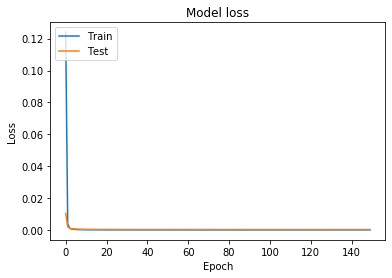

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluate topic extraction

## Clustering

### K-Means
Summary: Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [19]:
def clusterNumberHeuristic(tfs):
    return (tfs.shape[0]*tfs.shape[1])//tfs.count_nonzero()

def clusterkm(tfs_reduced, num_topics=10):
    print('K-Means:')
    km = %time KMeans(n_clusters=num_topics).fit(tfs_reduced)
    return km

### Agglomerative Clustering

In [20]:
ind = triu_indices(docs_vectorized_doc2vec.shape[0], 1)
wmds = np.zeros((docs_vectorized_doc2vec.shape[0], docs_vectorized_doc2vec.shape[0]))
euds = np.zeros((docs_vectorized_doc2vec.shape[0], docs_vectorized_doc2vec.shape[0]))
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

def wmd(x):
    return doc2vec_model.wv.wmdistance(mfndata[x[0]].words, mfndata[x[1]].words)

def eud(x):
    return norm(doc2vec_model[x[0]] - doc2vec_model[x[1]])

with Pool(cpu_count()) as p:
    wmds[ind] = p.map(wmd, zip(*ind))
    euds[ind] = p.map(eud, zip(*ind))
wmds = symmetrize(wmds)
euds = symmetrize(euds)

In [36]:
fig = go.Figure(data=[go.Box(y=(wmds/euds).flatten(),
            boxpoints='all', # can also be outliers, or suspectedoutliers, or False
            jitter=0.3, # add some jitter for a better separation between points
            pointpos=-1.8, # relative position of points wrt box
            name=""
              )])
fig.update_layout(
    title=go.layout.Title(
        xref="paper",
        x=0
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Quotient between WMD and Euclidian distance",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()

/tf/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [41]:
def clusterag(tfs_reduced, num_clusters=5):
    print('Agglomerative Clustering:')
    am = %time AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', memory='/tmp', linkage='average').fit(wmds)
    return am

# Embedding into 2D

## Linear Discriminant Analysis
*Summary*:
Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [42]:
def dimReductionLDA(tfs_reduced, clusters, targetDim=2):
    lda = LinearDiscriminantAnalysis(n_components=targetDim)
    print('LDA:')
    tfs_2d = %time lda.fit(tfs_reduced, clusters.labels_).transform(tfs_reduced)
    return tfs_2d, lda

## tSNE
*Summary*:


*In-depth explanation*:

In [43]:
def dimReductiontSNE(tfs_reduced, perplexity=30, learning_rate=100, targetDim=2):
    print('t-SNE:')
    tfs_2d = %time TSNE(n_components=targetDim, perplexity=perplexity, learning_rate=learning_rate).fit_transform(tfs_reduced)
    return tfs_2d

# Linearize results into a grid

In [44]:
def mapToSpaceSampling(points):
    # just take the first n² < #points Points
    points = points[: int(np.sqrt(len(points)))**2]
    grid = np.dstack(np.meshgrid(np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), int(np.sqrt(len(points)))),
                       np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), int(np.sqrt(len(points)))))).reshape(-1, 2)
    cost = cdist(points, grid, "sqeuclidean").astype(np.float64)
    print(cost.shape)
    cost *= 100000 / cost.max()
    row_ind_lapjv, col_ind_lapjv, _ = lapjv(cost, verbose=True, force_doubles=True)
    return grid[row_ind_lapjv]

In [45]:
def computeClusterTopography(points, values, width, height, interpolation='linear'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [91]:
def compute(tfs, emb_model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height):
    
    if dimreduction == 'LSA':
        tfs_reduced, red_model = LSA(tfs, num_topics=num_topics)
    elif dimreduction == 'Autoencoder':
        print('Autoencoder:')
        tfs_reduced, red_model = encoder.predict(tfs), None
    else:
        return 'No dimensionality reduction technique was selected!'
    
    if clustering == 'KMEANS':
        clusters = clusterkm(tfs_reduced, num_topics=num_clusters)
        cluster_centers_ = clusters.cluster_centers_
    elif clustering == 'Agglomerative Clustering':
        clusters = clusterag(tfs_reduced, num_clusters=num_clusters)
        cluster_centers_ = [np.mean(tfs[clusters.labels_[clusters.labels_ == x]]) for x in range(num_clusters)]
    else:
        return 'No clustering technique was selected!'
    
    sim_kernel = 1/(1+wmds)
    if embedding == 'LDA':
        tfs_embedded, lda = dimReductionLDA(tfs_reduced, clusters=clusters, targetDim=targetDim)
    elif embedding == 'tSNE':
        tfs_embedded = dimReductiontSNE(tfs_reduced, perplexity=perplexity, learning_rate=learning_rate, targetDim=targetDim)
    else:
        return 'No dimensionality reduction technique was selected!'
    
    # compute linearization
    tfs_mapped = mapToSpaceSampling(tfs_embedded) if targetDim == 2 else np.array([[0,0]]*len(tfs_embedded)) 
    
    # compute top words
    cluster_words = [emb_model.top_words(np.mean(tfs[clusters.labels_==cluster], axis=0), dct=dct, topn=5) for cluster in range(num_clusters)]
    top_words = [emb_model.top_words(project, dct=dct, topn=5) for project in tfs]
    # compute coherence score
    cm = CoherenceModel(topics=cluster_words, corpus=mfncorpus, dictionary=dct, coherence='u_mass')
    print("Coherence score: ", cm.get_coherence())
    
    #compute cluster topography
    similarity_to_cluster_centers = [norm(x-cluster_centers_[clusters.labels_[i]]) for i,x in enumerate(tfs_reduced)]
    similarity_to_cluster_centers = similarity_to_cluster_centers / -norm(similarity_to_cluster_centers)
    #reduction_error = np.max(lda.decision_function(tfs_reduced), axis=1) if (embedding == 'LDA') else [0]* len(tfs_embedded)
    #eduction_error = reduction_error / norm(reduction_error)
    interpolated_topography = computeClusterTopography(tfs_embedded if viz == 'scatter' else tfs_mapped, similarity_to_cluster_centers if error=='cluster_error' else silhouette_samples(tfs_reduced, clusters.labels_), width, height, interpolation)
    interpolated_topography = np.array([1])*len(interpolated_topography)
    return tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, interpolated_topography, cm

# Visualization

In [57]:
def draw_scatter(data, width=600, height=600, viz='scatter'):
    display(Javascript("""
        (function(element){
            require(['scatter'], function(scatter) {
                scatter(element.get(0), %s, %d, %d, %s);
            });
        })(element);
    """ % (json.dumps(data), width, height, json.dumps(viz))))

In [58]:
def save(payload):
    name = "c" + str(payload['params']['num_clusters']) +"-t" + str(payload['params']['num_topics']) + "_" + str(payload['params']['embedding'])
    if payload['params']['embedding'] == 'tSNE':
        name += "_p" + str(payload['params']['perplexity']) + "-lr" + str(payload['params']['learning_rate'])
    with open('./dumps/' + name + '.json', 'w') as dumpfile:
        json.dump(payload, dumpfile, sort_keys=True, indent=4, ensure_ascii=False)

In [59]:
def visualize(targetDim=2,tfs=None,dimreduction='LSA', clustering='KMEANS', embedding='LDA', num_topics=20, num_clusters=5, perplexity=5, learning_rate=200, error='cluster_error', interpolation='linear', viz='scatter', fake=''):
    # viz dimensions
    width = 600
    height = 600
    payload = {}
    
    
    if not fake:
        # compute all necessary stuff
        tfs, model = pickle.loads(tfs)
        tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, interpolated_topography, cm = compute(tfs, model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height)

        [print(i, words) for i,words in enumerate(cluster_words)]
        colours = inferno(num_clusters)
        #ids, titles, texts = [list(elem) for elem in zip(*loadProjects())]
        if targetDim == 2:
            # configure bokeh plot                   
            source = ColumnDataSource(data=dict(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                x_mapped=tfs_mapped[:, 0],
                y_mapped=tfs_mapped[:, 1],
                ids=mfndata.getIDs(),
                titles=mfndata.getTitles(),
                colours=np.array(colours)[clusters.labels_],
                labels=clusters.labels_
            ))

            TOOLTIPS = [
                ("index", "$index"),
                ("id", "@ids"),
                ("title", "@titles"),
            ]
            # scatterplot
            scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom,save')
            scatter.scatter('x', 'y', size=10,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)

            # mapped scatterplot
            mapped_scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom')
            mapped_scatter.scatter('x_mapped', 'y_mapped', size=50,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = mapped_scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)
            #show(row(scatter, mapped_scatter))
        else:

            source = go.Scatter3d(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                z=tfs_embedded[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=clusters.labels_,                # set color to an array/list of desired values
                    colorscale='Viridis',   # choose a colorscale
                    opacity=0.8
                )
            )

            data = [source]
            layout = go.Layout(
                margin=dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0
                )
            )
            fig = go.Figure(data=data, layout=layout)
            iplot(fig, filename='3d-scatter-colorscale')

        payload = {
            'params': {
                'targetDim': targetDim,
                'dimreduction': dimreduction,
                'clustering': clustering,
                'embedding': embedding,
                'num_topics': num_topics,
                'num_clusters': num_clusters,
                'perplexity': perplexity,
                'learning_rate': learning_rate
            },
            'project_data': [{'id':pid,'reducedpoint': reducedpoint, 'embpoint':embpoint, 'mappoint':mappoint, 'cluster':cluster, 'error':error, 'title': title, 'words': words} for pid, reducedpoint, embpoint, mappoint, cluster, error, title, words in zip(
                mfndata.getIDs(),
                tfs_reduced.tolist(),
                tfs_embedded.tolist(),
                tfs_mapped.tolist(),
                clusters.labels_.tolist(),
                similarity_to_cluster_centers.tolist(),
                mfndata.getTitles(),
                top_words

            )],
            'cluster_data': {
                'cluster_words': cluster_words,
                'cluster_colour': colours
            },
            'cluster_topography': np.flip(interpolated_topography.T, axis=0).flatten().tolist()
        }
        save(payload)
    else:
        with open(fake, 'r') as input_data:
            payload = payload=json.load(input_data)
    display(HTML(filename="scatter.css.html"))
    display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
    display(Javascript(filename="scatter.js"))
    draw_scatter(payload, width, height, viz)
        


In [60]:
def s(x,y):
    return IntSlider(min=x,max=y, value=(y-x)//2, continuous_update=False)

def f(x,y):
    return FloatSlider(min=x,max=y, value=(y-x)//2, step=0.0001, continuous_update=False)

w = interactive(visualize,targetDim=s(2,3),tfs=Dropdown(options=[('Doc2Vec', pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), ('TfIdf', pickle.dumps((docs_vectorized_tfidf, tfidf_model)))], value=pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), dimreduction=['LSA', 'Autoencoder'], clustering=['KMEANS', 'Agglomerative Clustering'], embedding=['LDA', 'tSNE'], num_topics=s(4,48), num_clusters=s(3,10), perplexity=s(5,50), learning_rate=s(100,1000),error=['silhouette', 'cluster_error'], interpolation=['linear', 'cubic', 'nearest'], viz=['scatter', 'linearized'], fake='')
output = w.children[-1]
#output.layout.height = '2000px'
display(w)


interactive(children=(IntSlider(value=2, continuous_update=False, description='targetDim', max=3, min=2), Drop…

In [98]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Doc2Vec + LSA", "Doc2Vec + Autoencoder", "TfIdf + LSA", "TfIdf + Autoencoder")
)

# Update xaxis properties
#fig.update_xaxes(title_text="xaxis 1 title", row=1, col=1)
#fig.update_xaxes(title_text="xaxis 2 title", range=[10, 50], row=1, col=2)
#fig.update_xaxes(title_text="xaxis 3 title", showgrid=False, row=2, col=1)
#fig.update_xaxes(title_text="xaxis 4 title", type="log", row=2, col=2)

# Update yaxis properties
#fig.update_yaxes(title_text="yaxis 1 title", row=1, col=1)
#fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)
#fig.update_yaxes(title_text="yaxis 3 title", showgrid=False, row=2, col=1)
#fig.update_yaxes(title_text="yaxis 4 title", row=2, col=2)

# Update title and height
#fig.update_layout(title_text="Customizing Subplot Axes", height=700)

def compute_cms(num_clusters):
    cms = []
    for rerun in range(5):
        tfs, model = pickle.loads(embmodel)
        *args, cm = compute(tfs, model, 2, dimreduction, clustering, 'LDA', 50, num_clusters, 5, 100, 'cluster_error', 'linear', 'scatter', 10, 10)
        print(cm)
        cms.append(cm.get_coherence())
    return sum(cms)/len(cms)


for i,(name,embmodel) in enumerate([('Doc2Vec', pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), ('TfIdf', pickle.dumps((docs_vectorized_tfidf, tfidf_model)))]):
    for j,dimreduction in enumerate(['LSA', 'Autoencoder']):
        if name == 'TfIdf' and dimreduction =='Autoencoder':
            continue
        for clustering in ['KMEANS', 'Agglomerative Clustering']:
            data = []
            dims = list(range(4, 48))
            if not dimreduction == 'Autoencoder':
                with Pool(cpu_count()) as p:
                    data = p.map(compute_cms, dims)
            else:
                data = [compute_cms(dim) for dim in dims]
            fig.add_trace(go.Scatter(x=dims, y=data, name=clustering, marker_color="red" if clustering == 'KMEANS' else "blue", showlegend=True if (i==0 and j==0) else False), row=i+1, col=j+1)

fig.show()

LSA:
LSA:
LSA:
LSA:
CPU times: user 340 ms, sys: 198 ms, total: 538 ms
Wall time: 552 ms
K-Means:
CPU times: user 68.9 ms, sys: 38.9 ms, total: 108 ms
Wall time: 237 ms
LDA:
CPU times: user 12.2 ms, sys: 19 ms, total: 31.1 ms
Wall time: 33.8 ms
(81, 81)
CPU times: user 1.34 s, sys: 744 ms, total: 2.09 s
Wall time: 1.68 s
K-Means:
CPU times: user 1.32 s, sys: 632 ms, total: 1.95 s
Wall time: 1.92 s
K-Means:
CPU times: user 121 ms, sys: 18.4 ms, total: 140 ms
Wall time: 335 ms
LDA:
CPU times: user 22.7 ms, sys: 13.4 ms, total: 36.1 ms
Wall time: 48.9 ms
(81, 81)
CPU times: user 1.32 s, sys: 554 ms, total: 1.87 s
Wall time: 2.11 s
K-Means:
CPU times: user 183 ms, sys: 29.3 ms, total: 212 ms
Wall time: 566 ms
LDA:
CPU times: user 93.5 ms, sys: 58.4 ms, total: 152 ms
Wall time: 163 ms
LDA:
CPU times: user 5.52 ms, sys: 20.7 ms, total: 26.2 ms
CPU times: user 13.5 ms, sys: 15.5 ms, total: 29 ms
Wall time: 29.6 ms
Wall time: 33.7 ms
(81, 81)
(81, 81)
Coherence score:  -4.644860373732859
Coher

CPU times: user 185 ms, sys: 157 ms, total: 342 ms
Wall time: 231 ms
K-Means:
CPU times: user 135 ms, sys: 37.3 ms, total: 173 ms
Wall time: 190 ms
CPU times: user 76.6 ms, sys: 42.3 ms, total: 119 ms
Wall time: 59.5 ms
LDA:
CPU times: user 14.1 ms, sys: 3.05 ms, total: 17.1 ms
Wall time: 15.1 ms
LDA:
(81, 81)
CPU times: user 11.8 ms, sys: 31.9 ms, total: 43.6 ms
Wall time: 70.1 ms
(81, 81)
LSA:
LSA:
CPU times: user 230 ms, sys: 232 ms, total: 462 ms
Wall time: 390 ms
K-Means:
CPU times: user 197 ms, sys: 45.1 ms, total: 243 ms
Wall time: 686 ms
LDA:
CPU times: user 13.4 ms, sys: 15.2 ms, total: 28.6 ms
Wall time: 26.7 ms
(81, 81)
Coherence score:  -4.679517732758807
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.43 s, sys: 525 ms, total: 1.95 s
Wall time: 1.77 s
K-Means:
Coherence score:

LSA:
Wall time: 6.37 ms
(81, 81)
LSA:
CPU times: user 789 ms, sys: 326 ms, total: 1.12 s
Wall time: 779 ms
K-Means:
CPU times: user 153 ms, sys: 48.6 ms, total: 202 ms
Wall time: 399 ms
LDA:
CPU times: user 24.4 ms, sys: 10.2 ms, total: 34.6 ms
Wall time: 45.6 ms
(81, 81)
Coherence score:  -1.8579441494931437
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 1.5 s, sys: 731 ms, total: 2.23 s
Wall time: 1.93 s
K-Means:
CPU times: user 141 ms, sys: 23.2 ms, total: 164 ms
Wall time: 389 ms
LDA:
CPU times: user 12.2 ms, sys: 145 µs, total: 12.3 ms
Wall time: 10.6 ms
(81, 81)
CPU times: user 854 ms, sys: 480 ms, total: 1.33 s
Wall time: 1.14 s
K-Means:
Coherence score:  -4.06800068588821
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7

LSA:
LSA:
CPU times: user 1.02 s, sys: 367 ms, total: 1.38 s
Wall time: 770 ms
K-Means:
LSA:
CPU times: user 122 ms, sys: 48 ms, total: 170 ms
Wall time: 211 ms
LDA:
CPU times: user 6.7 ms, sys: 5.2 ms, total: 11.9 ms
Wall time: 7.99 ms
(81, 81)
CPU times: user 996 ms, sys: 534 ms, total: 1.53 s
Wall time: 1.5 s
K-Means:
CPU times: user 82.1 ms, sys: 49.3 ms, total: 131 ms
Wall time: 310 ms
CPU times: user 1.2 s, sys: 714 ms, total: 1.92 s
LDA:
Wall time: 1.67 s
K-Means:
CPU times: user 14.4 ms, sys: 7.23 ms, total: 21.6 ms
Wall time: 14.3 ms
(81, 81)
CPU times: user 1.4 s, sys: 678 ms, total: 2.07 s
Wall time: 2.12 s
K-Means:
CPU times: user 149 ms, sys: 38.7 ms, total: 188 ms
Wall time: 276 ms
LDA:
CPU times: user 9.31 ms, sys: 11.6 ms, total: 20.9 ms
Wall time: 21.1 ms
(81, 81)
Coherence score:  -3.886120248788915
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d85

Wall time: 850 ms
K-Means:
CPU times: user 194 ms, sys: 72.7 ms, total: 267 ms
Wall time: 207 ms
LDA:
CPU times: user 7.8 ms, sys: 23.8 ms, total: 31.6 ms
LSA:
Wall time: 25.5 ms
(81, 81)
CPU times: user 497 ms, sys: 361 ms, total: 858 ms
Wall time: 646 ms
K-Means:
CPU times: user 216 ms, sys: 27.8 ms, total: 244 ms
Wall time: 580 ms
LDA:
CPU times: user 10.5 ms, sys: 7.21 ms, total: 17.7 ms
Wall time: 14.5 ms
(81, 81)
CPU times: user 285 ms, sys: 42.6 ms, total: 327 ms
Wall time: 916 ms
LDA:
CPU times: user 11.7 ms, sys: 27.6 ms, total: 39.3 ms
CPU times: user 891 ms, sys: 505 ms, total: 1.4 s
Wall time: 27.3 ms
Wall time: 1.17 s
(81, 81)
K-Means:
Coherence score:  -3.7077445162192775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 198 ms, sys: 17.9 ms, total: 216 ms
Wall time: 475 ms
LDA:


Wall time: 1.23 s
Wall time: 7.62 ms
(81, 81)
K-Means:
CPU times: user 216 ms, sys: 35.9 ms, total: 252 ms
Wall time: 611 ms
LDA:
CPU times: user 8.54 ms, sys: 0 ns, total: 8.54 ms
Wall time: 6.54 ms
(81, 81)
Coherence score:  -4.226828748488172
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.9854049174193404
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.597495591805915
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74

Coherence score:  -4.687315138685382
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 271 ms, sys: 20 ms, total: 291 ms
Wall time: 942 ms
LDA:
CPU times: user 15.7 ms, sys: 1.35 ms, total: 17 ms
Wall time: 11.6 ms
(81, 81)
Coherence score:  -4.453945605873709
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 99.4 ms, sys: 57.8 ms, total: 157 ms
Wall time: 93 ms
K-Means:
CPU times: user 238 ms, sys: 37 ms, total: 275 ms
Wall time: 577 ms
LDA:
CPU times: user 24 ms, sys: 512 µs, total: 24.5 ms
Wall time: 16.7 ms
(81, 81)
LSA:
Coherence score:  -4.678522991218659
Coherence_Measure(seg=<function s_o

LSA:
CPU times: user 1.26 s, sys: 492 ms, total: 1.75 s
Wall time: 1.55 s
K-Means:
CPU times: user 270 ms, sys: 47.2 ms, total: 318 ms
Wall time: 531 ms
LDA:
CPU times: user 7.63 ms, sys: 21.7 ms, total: 29.4 ms
CPU times: user 581 ms, sys: 379 ms, total: 959 ms
Wall time: 22.8 ms
Wall time: 722 ms
K-Means:
(81, 81)
CPU times: user 240 ms, sys: 40 ms, total: 280 ms
Wall time: 368 ms
LDA:
CPU times: user 16.5 ms, sys: 9.23 ms, total: 25.7 ms
Wall time: 16.8 ms
(81, 81)
Coherence score:  -3.2269697013073446
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.7040949267242
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.1 ms, sys: 24.3 ms, total: 39.4 ms
Wall time: 43.9 ms
(81, 81)
CPU times: user 253 ms, sys: 21.4 ms, total: 274 ms
Wall time: 562 ms
LDA:
CPU times: user 4.52 ms, sys: 4.23 ms, total: 8.76 ms
Wall time: 7.05 ms
(81, 81)
Coherence score:  -4.539577224933102
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.44 s, sys: 669 ms, total: 2.11 s
Wall time: 1.75 s
K-Means:
LSA:
CPU times: user 271 ms, sys: 185 ms, total: 455 ms
Wall time: 398 ms
K-Means:
CPU times: user 330 ms, sys: 48.5 ms, total: 379 ms
Wall time: 936 ms
LDA:
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 8.79 ms
(81, 81)
Coherence score:  -4.599726807136533
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditi

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.9 ms, sys: 19 ms, total: 40.8 ms
Wall time: 851 ms
Wall time: 32.8 ms
K-Means:
(81, 81)
CPU times: user 669 ms, sys: 406 ms, total: 1.08 s
Wall time: 791 ms
K-Means:
CPU times: user 250 ms, sys: 77 ms, total: 327 ms
Wall time: 230 ms
LDA:
CPU times: user 267 ms, sys: 27.1 ms, total: 294 ms
Wall time: 502 ms
CPU times: user 5.99 ms, sys: 11.5 ms, total: 17.4 ms
LDA:
Wall time: 17 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.2 ms, sys: 11.7 ms, total: 39.9 ms
Wall time: 27 ms
(81, 81)
LSA:
Coherence score:  -4.180039867408777
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.865799212513784
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 869 ms, sys: 450 ms, total: 1.32 s
Wall time: 1.27 s
K-Means:
Coherence score:  -4.267694235876287
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 290 ms, sys: 33

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 40.4 ms, sys: 18 ms, total: 58.4 ms
Wall time: 44.4 ms
(81, 81)
CPU times: user 909 ms, sys: 566 ms, total: 1.47 s
Wall time: 1.13 s
K-Means:
LSA:
CPU times: user 137 ms, sys: 94.8 ms, total: 232 ms
Wall time: 197 ms
K-Means:
CPU times: user 345 ms, sys: 0 ns, total: 345 ms
Wall time: 764 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.2 ms, sys: 42.6 ms, total: 61.8 ms
Wall time: 63.8 ms
(81, 81)
Coherence score:  -4.8114704432135404
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.640571991307651
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 283 ms, sys: 21 ms, total: 304 ms
Wall time: 707 ms
LDA:
CPU times: user 5.9 ms, sys: 5.11 ms, total: 11 ms
Wall time: 6.31 ms
(81, 81)
LSA:
Coherence score:  -4.35250691449357
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<funct

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.2 ms, sys: 23.6 ms, total: 50.8 ms
Wall time: 32.1 ms
(81, 81)
CPU times: user 252 ms, sys: 59.6 ms, total: 312 ms
Wall time: 337 ms
LDA:
LSA:
CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 5.87 ms
(81, 81)
CPU times: user 406 ms, sys: 233 ms, total: 639 ms
Wall time: 427 ms
K-Means:
CPU times: user 363 ms, sys: 15.6 ms, total: 379 ms
Wall time: 835 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.2 ms, sys: 4.13 ms, total: 28.4 ms
Wall time: 18.5 ms
(81, 81)
Coherence score:  -4.4938817845528884
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.612400117666726
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
Coherence score:  -4.062564850408381
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 877 ms, sys: 409 ms, total: 1.29 s
Wall time: 1.01 s
K-Means:
CPU times: user 300 ms, sys:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 8.65 ms, sys: 30.4 ms, total: 39.1 ms
Wall time: 36 ms
(81, 81)
CPU times: user 1.32 s, sys: 713 ms, total: 2.03 s
Wall time: 1.41 s
K-Means:
CPU times: user 274 ms, sys: 55.5 ms, total: 330 ms
Wall time: 399 ms
LDA:
CPU times: user 12.3 ms, sys: 10 ms, total: 22.4 ms
Wall time: 26.2 ms
(81, 81)
LSA:
Coherence score:  -4.682186934839356
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 919 ms, sys: 463 ms, total: 1.38 s
Wall time: 859 ms
K-Means:
CPU times: user 332 ms, sys: 68 ms, total: 400 ms
Wall time: 302 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.7 ms, sys: 23.3 ms, total: 38 ms
Wall time: 27.5 ms
(81, 81)
Coherence score:  -3.802001471430897
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.389743019329081
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.617173684735034
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 1.2 s, sys: 554 ms, total: 1.75 s
Wall time: 933 ms
K-Means:
LSA:
CPU times: user 1.06 s, sys

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.5 ms, sys: 35.9 ms, total: 64.4 ms
Wall time: 73.5 ms
(81, 81)
LSA:
CPU times: user 245 ms, sys: 26.5 ms, total: 271 ms
Wall time: 691 ms
LDA:
CPU times: user 9.47 ms, sys: 0 ns, total: 9.47 ms
Wall time: 5.53 ms
(81, 81)
CPU times: user 565 ms, sys: 366 ms, total: 931 ms
Wall time: 906 ms
K-Means:
CPU times: user 1.11 s, sys: 650 ms, total: 1.76 s
Wall time: 1.52 s
K-Means:
Coherence score:  -4.4938817845528884
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 302 ms, sys: 31 ms, total: 333 ms
CPU times: user 363 ms, sys: 3.78 ms, total: 367 ms
Wall time: 699 ms
LDA:
Wall time: 869 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 34.8 ms, sys: 12.7 ms, total: 47.5 ms
Wall time: 42.1 ms
(81, 81)
CPU times: user 31.5 ms, sys: 28.4 ms, total: 59.9 ms
Wall time: 95.7 ms
(81, 81)
Coherence score:  -4.202420469166488
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.684319881188299
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -5.063996944548102
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 948 ms, s

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.5 ms, sys: 37.6 ms, total: 57.1 ms
Wall time: 41.4 ms
(81, 81)
CPU times: user 356 ms, sys: 84.7 ms, total: 441 ms
Wall time: 543 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.6 ms, sys: 18.9 ms, total: 29.5 ms
Wall time: 47.5 ms
(81, 81)
LSA:
CPU times: user 614 ms, sys: 351 ms, total: 965 ms
Wall time: 856 ms
K-Means:
Coherence score:  -4.379725355498662
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.8866890666717224
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 357 ms, sys: 5.71 ms, total: 362 ms
Wall time: 1.06 s
LDA:
CPU times: user 30.5 ms, sys: 4.63 ms, total: 35.1 ms
Wall time: 39.1 ms
Coherence score:  -4.219833843815013
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.1 ms, sys: 13.4 ms, total: 28.5 ms
Wall time: 21.1 ms
(81, 81)
CPU times: user 789 ms, sys: 504 ms, total: 1.29 s
Wall time: 898 ms
K-Means:
Coherence score:  -4.252563549975047
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.131155402131347
CPU times: user 420 ms, sys: 22 ms, total: 442 ms
Wall time: 1.35 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 75.5 ms, sys: 0 ns, total: 75.5 ms
Wall time: 58.7 ms
(81, 81)
Coherence score:  -5.012819115402035
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 526 ms, sys: 407 ms, total: 933 ms
Wall time: 676 ms
K-Means:
Coherence score:  -4.352544140207614
CPU times: user 753 ms, sys: 378 ms, total: 1.13 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Wall time: 807 ms
K-Means:
CPU times: user 293 ms, sys: 40 ms, total: 333 ms
Wall time: 767 ms
LDA:
CPU times: user 21.5 ms, sys: 44 ms, total: 65.6 ms
Wall time: 56.6 ms
(81, 81)
LSA:
CPU times: user 275 ms, sys: 63.5 ms, total: 338 ms
Wall time: 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 8.55 ms, sys: 34.1 ms, total: 42.6 ms
Wall time: 46 ms
(81, 81)
CPU times: user 1.28 s, sys: 728 ms, total: 2.01 s
Wall time: 1.59 s
K-Means:
Coherence score:  -5.146140540731665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 274 ms, sys: 55.3 ms, total: 329 ms
Wall time: 563 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.6 ms, sys: 36 ms, total: 52.6 ms
Wall time: 40.3 ms
(81, 81)
Coherence score:  -4.1238591160214835
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.145557013556693
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 472 ms, sys: 383 ms, total: 855 ms
Wall time: 721 ms
K-Means:
Coherence score:  -4.978322983370806
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 283 ms, sys: 4

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.9 ms, sys: 14.7 ms, total: 40.7 ms
Wall time: 33 ms
(81, 81)
Coherence score:  -4.226410428391193
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 883 ms, sys: 467 ms, total: 1.35 s
Wall time: 1.22 s
K-Means:
CPU times: user 1.16 s, sys: 683 ms, total: 1.84 s
Wall time: 1.7 s
K-Means:
LSA:
CPU times: user 331 ms, sys: 12.1 ms, total: 343 ms
Wall time: 691 ms
LDA:
CPU times: user 325 ms, sys: 32.8 ms, total: 358 ms
Wall time: 474 ms
CPU times: user 15.5 ms, sys: 23.7 ms, total: 39.2 ms
Wall time: 42.5 ms
LDA:
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.2 ms, sys: 22.2 ms, total: 34.4 ms
Wall time: 31.4 ms
(81, 81)
Coherence score:  -4.314505153726064
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.07 s, sys: 640 ms, total: 1.71 s
Wall time: 1.39 s
K-Means:
Coherence score:  -4.397715436653942
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 339 ms, sys: 7.97 ms, total: 347 ms
Wall time: 831 ms
LDA:
CPU times: user 30.3 ms, sys: 30.9 ms, total: 61.2 ms
Wall time: 57.1 ms
(81, 81)
Coherence score:  -4.684319881188299
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c48

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.1 ms, sys: 13 ms, total: 23.1 ms
Wall time: 27.9 ms
(81, 81)
CPU times: user 321 ms, sys: 11.4 ms, total: 332 ms
Wall time: 574 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 31.7 ms, sys: 18 ms, total: 49.7 ms
Wall time: 47.7 ms
(81, 81)
Coherence score:  -4.97832298337055
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.1922719859962525
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 767 ms, sys: 499 ms, total: 1.27 s
Wall time: 1.01 s
K-Means:
Coherence score:  -4.489687934853445
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 308 ms, sys: 47.6 ms

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.3 ms, sys: 12.9 ms, total: 37.2 ms
Wall time: 29.1 ms
(81, 81)
LSA:
CPU times: user 326 ms, sys: 83.1 ms, total: 409 ms
Wall time: 449 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.9 ms, sys: 21.8 ms, total: 41.8 ms
Wall time: 42.7 ms
(81, 81)
Coherence score:  -4.3164751535591614
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.2 s, sys: 667 ms, total: 1.87 s
Wall time: 1.86 s
K-Means:
Coherence score:  -4.203876816451036
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.687074601428758
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 244 ms, sys: 24.9 ms, t

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.6 ms, sys: 26 ms, total: 53.6 ms
Wall time: 47 ms
(81, 81)
Coherence score:  -4.613482126202265
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.12 s, sys: 643 ms, total: 1.76 s
Wall time: 1.43 s
K-Means:
CPU times: user 811 ms, sys: 501 ms, total: 1.31 s
Wall time: 1.16 s
K-Means:
CPU times: user 351 ms, sys: 47.6 ms, total: 398 ms
Wall time: 413 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 33.9 ms, sys: 37.2 ms, total: 71 ms
Wall time: 52.5 ms
(81, 81)
CPU times: user 346 ms, sys: 34.2 ms, total: 380 ms
Wall time: 691 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.5 ms, sys: 42.1 ms, total: 62.6 ms
Wall time: 50.8 ms
(81, 81)
Coherence score:  -4.827464711147201
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -3.489282912800039
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.493538752523222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.38 s, sys: 528 ms, total: 1.91 s
Wall time: 1.24 s
K-Means:
CPU times: user 556 ms, sys: 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.8 ms, sys: 25 ms, total: 48.7 ms
Wall time: 66.1 ms
(81, 81)
CPU times: user 23.7 ms, sys: 53.6 ms, total: 77.3 ms
Wall time: 97.4 ms
(81, 81)
CPU times: user 1.05 s, sys: 401 ms, total: 1.45 s
Wall time: 1.23 s
K-Means:
CPU times: user 871 ms, sys: 595 ms, total: 1.47 s
Wall time: 1.18 s
K-Means:
CPU times: user 326 ms, sys: 32 ms, total: 358 ms
Wall time: 919 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 17.5 ms, sys: 19.1 ms, total: 36.6 ms
Wall time: 37.1 ms
(81, 81)
CPU times: user 340 ms, sys: 19.5 ms, total: 360 ms
Wall time: 922 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.7 ms, sys: 19.4 ms, total: 38.1 ms
Wall time: 27 ms
(81, 81)
Coherence score:  -4.919870053607818
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.965678848567301
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.554199884488623
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.968218055805771
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boo

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 274 ms, sys: 24.8 ms, total: 299 ms
Wall time: 553 ms
CPU times: user 30.4 ms, sys: 41.1 ms, total: 71.5 ms
CPU times: user 326 ms, sys: 37.9 ms, total: 364 ms
Wall time: 69 ms
LDA:
Wall time: 464 ms
(81, 81)
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.9 ms, sys: 40.5 ms, total: 62.4 ms
CPU times: user 31.1 ms, sys: 23.7 ms, total: 54.8 ms
Wall time: 68.9 ms
Wall time: 55.8 ms
(81, 81)
(81, 81)
CPU times: user 351 ms, sys: 59.8 ms, total: 411 ms
Wall time: 610 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.1 ms, sys: 57.2 ms, total: 80.3 ms
Wall time: 65.4 ms
(81, 81)
Coherence score:  -4.3348280048422
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.081223231584482
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.369819137988657
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.8665368773531186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_bo

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.1 ms, sys: 11.1 ms, total: 33.3 ms
Wall time: 18.1 ms
(81, 81)
LSA:
CPU times: user 601 ms, sys: 340 ms, total: 942 ms
Wall time: 631 ms
K-Means:
CPU times: user 347 ms, sys: 260 ms, total: 607 ms
Wall time: 473 ms
K-Means:
CPU times: user 313 ms, sys: 34.4 ms, total: 348 ms
Wall time: 683 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.9 ms, sys: 16.9 ms, total: 44.8 ms
Wall time: 37 ms
(81, 81)
CPU times: user 879 ms, sys: 439 ms, total: 1.32 s
Wall time: 1.24 s
K-Means:
CPU times: user 347 ms, sys: 20.6 ms, total: 367 ms
Wall time: 912 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.4 ms, sys: 18.2 ms, total: 31.6 ms
Wall time: 33.5 ms
(81, 81)
Coherence score:  -4.1568406507114215
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 304 ms, sys: 26.3 ms, total: 330 ms
Wall time: 1 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.6 ms, sys: 5.1 ms, total: 15.6 ms
Wall time: 12.2 ms
(81, 81)
Coherence score:  -4.144327324480103
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.190888538364081
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.254463948070476
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
CPU times: user 654 ms, sys: 381 ms, total: 1.03 s
CPU times: user 1.04 s, sys: 553 ms, total: 1.59 s
W

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.1 ms, sys: 35.7 ms, total: 58.8 ms
Wall time: 61.9 ms
(81, 81)
CPU times: user 325 ms, sys: 34.9 ms, total: 359 ms
Wall time: 789 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.8 ms, sys: 19.9 ms, total: 33.6 ms
Wall time: 29.1 ms
(81, 81)
CPU times: user 1.13 s, sys: 585 ms, total: 1.72 s
Wall time: 1.37 s
K-Means:
CPU times: user 1.07 s, sys: 565 ms, total: 1.63 s
Wall time: 1.24 s
K-Means:
CPU times: user 341 ms, sys: 55.3 ms, total: 397 ms
Wall time: 1.06 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 41.1 ms, sys: 10.4 ms, total: 51.5 ms
Wall time: 33.6 ms
(81, 81)
CPU times: user 418 ms, sys: 39.3 ms, total: 457 ms
Wall time: 1.11 s
LDA:
Coherence score:  -3.8596054055487485


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.4 ms, sys: 29.8 ms, total: 60.2 ms
Wall time: 54.6 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.564156431338923
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 67.6 ms, sys: 107 ms, total: 175 ms
Wall time: 105 ms
K-Means:
Coherence score:  -4.028858525326887
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 307 ms, sys: 71.2 ms, total: 378 ms
Wall time: 440 ms


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.9 ms, sys: 55.6 ms, total: 83.5 ms
Wall time: 49.4 ms
(81, 81)
LSA:
CPU times: user 40.7 ms, sys: 71.7 ms, total: 112 ms
Wall time: 72.3 ms
K-Means:
LSA:
CPU times: user 102 ms, sys: 121 ms, total: 223 ms
Wall time: 149 ms
K-Means:
CPU times: user 412 ms, sys: 17.3 ms, total: 429 ms
Wall time: 811 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.6 ms, sys: 16.6 ms, total: 39.2 ms
Wall time: 32.1 ms
(81, 81)
CPU times: user 412 ms, sys: 47.7 ms, total: 460 ms
Wall time: 820 ms
LDA:
Coherence score:  -4.1568406507114215


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.8 ms, sys: 40.7 ms, total: 69.4 ms
Wall time: 90.5 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.140102474393047
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.564156431338923
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
CPU times: user 1.16 s, sys: 560 ms, total: 1.72 s
Wall time: 1.14 s
K-Means:
CPU times: user 1.28 s, sys: 630 ms, total: 1.91 s
Wall time:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 9.92 ms, sys: 21.9 ms, total: 31.8 ms
Wall time: 30.3 ms
(81, 81)
CPU times: user 382 ms, sys: 11.4 ms, total: 394 ms
Wall time: 848 ms
CPU times: user 1.51 s, sys: 566 ms, total: 2.08 s
LDA:
Wall time: 1.66 s


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.2 ms, sys: 18.2 ms, total: 30.4 ms
Wall time: 21.3 ms
(81, 81)
K-Means:
Coherence score:  -3.9988096546729386
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 355 ms, sys: 16.8 ms, total: 372 ms
Wall time: 760 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 33 ms, sys: 21.6 ms, total: 54.6 ms
Wall time: 52.6 ms
(81, 81)
Coherence score:  -3.6146440440968886
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.924062457010123
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 792 ms, sys: 423 ms, total: 1.22 s
Wall time: 779 ms
K-Means:
LSA:
CPU times: user 773 ms, sys: 546 ms, total: 1.32 s
Wall time: 1.04 s
K-Means:
CPU times: user 363 ms, sys: 28 ms, total: 391 ms
Wall time: 824 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.3 ms, sys: 23.5 ms, total: 44.8 ms
Wall time: 41.7 ms
(81, 81)
Coherence score:  -4.4755813495007715
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 982 ms, sys: 459 ms, total: 1.44 s
Wall time: 1.24 s
K-Means:
CPU times: user 387 ms, sys: 18.3 ms, total: 405 ms
Wall time: 1.12 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.2 ms, sys: 13 ms, total: 27.2 ms
Wall time: 29.9 ms
(81, 81)
CPU times: user 383 ms, sys: 46.9 ms, total: 430 ms
Wall time: 728 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 37 ms, sys: 188 µs, total: 37.2 ms
Wall time: 30.4 ms
(81, 81)
Coherence score:  -4.115480137839886
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.35614249177597
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 492 ms, sys: 297 ms, total: 789 ms
Wall time: 533 ms
K-Means:
Coherence score:  -3.9680573334026503
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 320 ms, sys: 37.9 ms,

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13 ms, sys: 29.2 ms, total: 42.2 ms
Wall time: 22.7 ms
(81, 81)
LSA:
LSA:
Coherence score:  -4.168743570785116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.14 s, sys: 630 ms, total: 1.77 s
Wall time: 1.35 s
CPU times: user 915 ms, sys: 608 ms, total: 1.52 s
K-Means:
Wall time: 1.01 s
K-Means:
CPU times: user 326 ms, sys: 31.3 ms, total: 357 ms
Wall time: 310 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20 ms, sys: 18.1 ms, total: 38.1 ms
Wall time: 16.8 ms
(81, 81)
CPU times: user 350 ms, sys: 24.4 ms, total: 375 ms
Wall time: 490 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 64.1 ms, sys: 36.2 ms, total: 100 ms
Wall time: 67.3 ms
(81, 81)
LSA:
CPU times: user 653 ms, sys: 241 ms, total: 894 ms
Wall time: 696 ms
K-Means:
Coherence score:  -3.937293558842186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.968057333402649
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 373 ms, sys: 11.7 ms, total: 384 ms
Wall time: 850 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 42.4 ms, sys: 0 ns, total: 42.4 ms
Wall time: 32.4 ms
(81, 81)
LSA:
Coherence score:  -4.342058692656122
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.18 s, sys: 661 ms, total: 1.84 s
Wall time: 1.06 s
K-Means:
CPU times: user 1.02 s, sys: 527 ms, total: 1.55 s
Wall time: 874 ms
K-Means:
LSA:
CPU times: user 38.8 ms, sys: 35.2 ms, total: 73.9 ms
Wall time: 28.5 ms
K-Means:
CPU times: user 371 ms, sys: 53.5 ms, total: 424 ms
Wall time: 561 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.3 ms, sys: 38.1 ms, total: 60.4 ms
Wall time: 36 ms
(81, 81)
CPU times: user 342 ms, sys: 63.7 ms, total: 406 ms
Wall time: 381 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 40 ms, sys: 42.1 ms, total: 82.1 ms
Wall time: 51.1 ms
(81, 81)
CPU times: user 392 ms, sys: 52.4 ms, total: 444 ms
Wall time: 577 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.6 ms, sys: 6.91 ms, total: 28.6 ms
Wall time: 22.3 ms
(81, 81)
Coherence score:  -3.883630581628126
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.937293558842186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.055454293376997
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 878 ms, sys: 335 ms, total: 1.21 s
Wall time: 669 ms
K-Means:
CPU times: user 363 ms, sys: 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.4 ms, sys: 26.9 ms, total: 52.3 ms
Wall time: 54 ms
(81, 81)
LSA:
CPU times: user 1.18 s, sys: 582 ms, total: 1.76 s
Wall time: 1.08 s
K-Means:
CPU times: user 346 ms, sys: 26.7 ms, total: 373 ms
Wall time: 716 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.9 ms, sys: 28.8 ms, total: 55.7 ms
Wall time: 63.9 ms
(81, 81)
CPU times: user 1.05 s, sys: 575 ms, total: 1.62 s
Wall time: 1.16 s
K-Means:
Coherence score:  -3.985406960560994
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 336 ms, sys: 76.5 ms, total: 413 ms
Wall time: 502 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 41.7 ms, sys: 41.5 ms, total: 83.2 ms
Wall time: 71 ms
(81, 81)
Coherence score:  -3.5181841938692027
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.625748040642048
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 672 ms, sys: 468 ms, total: 1.14 s
Wall time: 600 ms
K-Means:
LSA:
LSA:
CPU times: user 347 ms, sys: 61.4 ms, total: 409 ms
Wall time: 434 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.4 ms, sys: 29.2 ms, total: 53.7 ms
Wall time: 33.7 ms
(81, 81)
CPU times: user 581 ms, sys: 422 ms, total: 1 s
Wall time: 701 ms
K-Means:
CPU times: user 733 ms, sys: 438 ms, total: 1.17 s
Wall time: 870 ms
K-Means:
CPU times: user 348 ms, sys: 20.3 ms, total: 368 ms
Wall time: 611 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.6 ms, sys: 35.1 ms, total: 65.7 ms
Wall time: 51.2 ms
(81, 81)
CPU times: user 365 ms, sys: 38 ms, total: 403 ms
Wall time: 704 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.1 ms, sys: 11.8 ms, total: 27.9 ms
Wall time: 18.5 ms
(81, 81)
Coherence score:  -3.7877533276361914
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.238676342830977
Coherence score:  -3.834879219350803
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 590 ms, sys: 407 ms, total: 997 ms
Wall time: 655 ms
K-Means:
LSA:
CPU times: user 406 ms, sys:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.4 ms, sys: 34.6 ms, total: 58 ms
Wall time: 44.7 ms
(81, 81)
CPU times: user 405 ms, sys: 218 ms, total: 623 ms
Wall time: 330 ms
K-Means:
CPU times: user 349 ms, sys: 85.6 ms, total: 435 ms
Wall time: 447 ms
LDA:
LSA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 36.9 ms, sys: 22.7 ms, total: 59.6 ms
CPU times: user 4.37 ms, sys: 22.3 ms, total: 26.7 ms
Wall time: 64 ms
(81, 81)
Wall time: 8.53 ms
K-Means:
CPU times: user 361 ms, sys: 34 ms, total: 395 ms
Wall time: 738 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.787753327636192
CPU times: user 20.2 ms, sys: 50.3 ms, total: 70.5 ms
Wall time: 56.8 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.517901105558793
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.571824160009526
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
CPU times: user 1.03 s, sys: 623 ms, total: 1.65 s
Wall time: 1 s
K-Means:
CPU times: user 766 ms, sys

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.4 ms, sys: 38.5 ms, total: 67.9 ms
Wall time: 45.2 ms
(81, 81)
CPU times: user 344 ms, sys: 62.5 ms, total: 407 ms
Wall time: 467 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 32.3 ms, sys: 49.7 ms, total: 82 ms
Wall time: 42.2 ms
(81, 81)
CPU times: user 399 ms, sys: 67.9 ms, total: 467 ms
Wall time: 542 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.4 ms, sys: 42.5 ms, total: 53 ms
Wall time: 43.1 ms
(81, 81)
Coherence score:  -3.8836305816281254
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.459860170151589
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.110926599100007
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 241 ms, sys: 72.3 ms, total: 313 ms
Wall time: 159 ms
K-Means:
LSA:
CPU times: user 342 ms, sys: 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.6 ms, sys: 50.4 ms, total: 71 ms
Wall time: 61.3 ms
(81, 81)
CPU times: user 326 ms, sys: 44.9 ms, total: 371 ms
Wall time: 370 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.9 ms, sys: 28.4 ms, total: 49.3 ms
Wall time: 31.9 ms
(81, 81)
Coherence score:  -4.238676342830977
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.9044883602674347
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 53.6 ms, sys: 42.9 ms, total: 96.5 ms
Wall time: 34.9 ms
K-Means:
CPU times: user 348 ms, sys: 158 ms, total: 506 ms
Wall time: 230 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 36.1 ms, sys: 18.2 ms, total: 54.2 ms
Wall time: 26.9 ms
(81, 81)
Coherence score:  -4.16253615880815
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 46.8 ms, sys: 59.4 ms, total: 106 ms
Wall time: 36.4 ms
K-Means:
CPU times: user 323 ms, sys: 185 ms, total: 509 ms
Wall time: 234 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.6 ms, sys: 27.3 ms, total: 46 ms
Wall time: 19.1 ms
(81, 81)
Coherence score:  -3.9560979199755777
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 40.7 ms, sys: 74.4 ms, total: 115 ms
Wall time: 38.3 ms
K-Means:
CPU times: user 319 ms, sys: 141 ms, total: 460 ms
Wall time: 234 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.4 ms, sys: 16.9 ms, total: 38.3 ms
Wall time: 20.8 ms
(81, 81)
Coherence score:  -3.956097919975578
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
LSA:
CPU times: user 618 ms, sys: 281 ms, total: 899 ms
Wall time: 944 ms
Agglomerative Clustering:
CPU times: user 4.35 ms, sys: 4.26 ms, total: 8.61 ms
Wall time: 6.29 ms
LDA:
CPU times: user 4.9 ms, sys: 8.72 ms, total: 13.6 ms
Wall time: 9.72 ms
(81, 81)
CPU times: user 1.17 s, sys: 604 ms, total: 1.77 s
Wall time: 1.85 s
Agglomerative Clustering:
CPU times: user 0 ns, sys: 9.23 ms, total: 9.23 ms
Wall time: 10.1 ms
LDA:
CPU times: user 12.6 ms, sys: 30.4 ms, total: 42.9 ms
Wall time: 29.5 ms
CPU times: user 1.09 s, sys: 690 ms, total: 1.78 s
(81, 81)
Wall time: 2.04 s
Agglomerative Clustering:
CPU times: user 1.42 s, sys: 6

Coherence score:  -1.6257011308065006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.965133235040825
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 1 s, sys: 410 ms, total: 1.42 s
CPU times: user 1.33 s, sys: 571 ms, total: 1.9 s
Wall time: 894 ms
Agglomerative Clustering:
Wall time: 1.19 s
CPU times: user 1.33 ms, sys: 2.74 ms, total: 4.08 ms
Wall time: 2.58 ms
LDA:
Agglomerative Clustering:
CPU times: user 351 µs, sys: 2.2 ms, total: 2.55 ms
Wall time: 2.29 ms
CPU times: user 13.9 ms, sys: 6.8 ms, total: 20.7 ms
LDA:
Wall time: 20.7 ms
(81, 81)
CPU times: user 8.08 ms, sys: 20.2

Coherence score:  -1.8247665753950517
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 580 ms, sys: 393 ms, total: 973 ms
Wall time: 1.01 s
Agglomerative Clustering:
CPU times: user 1.6 ms, sys: 838 µs, total: 2.44 ms
Wall time: 2.2 ms
LDA:
CPU times: user 13 ms, sys: 22.6 ms, total: 35.6 ms
Wall time: 30.4 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.251402261613001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>

Wall time: 428 ms
Agglomerative Clustering:
CPU times: user 10.9 ms, sys: 3.28 ms, total: 14.1 ms
Wall time: 10.3 ms
LDA:
CPU times: user 9.05 ms, sys: 8.51 ms, total: 17.6 ms
Wall time: 14.3 ms
(81, 81)
Coherence score:  -2.128894337960894
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.8063345897850007
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.709501884677501
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519

Coherence score:  -1.3445648450279328
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 696 ms, sys: 606 ms, total: 1.3 s
Wall time: 1.28 s
Agglomerative Clustering:
CPU times: user 4.34 ms, sys: 158 µs, total: 4.5 ms
Wall time: 2.88 ms
LDA:
CPU times: user 7.56 ms, sys: 7.79 ms, total: 15.3 ms
Wall time: 11.1 ms
(81, 81)
CPU times: user 1.17 s, sys: 559 ms, total: 1.73 s
Wall time: 1.73 s
Agglomerative Clustering:
CPU times: user 3.72 ms, sys: 1.73 ms, total: 5.45 ms
Wall time: 2.42 ms
LDA:
CPU times: user 6.39 ms, sys: 13.1 ms, total: 19.5 ms
Wall time: 12.8 ms
(81, 81)
LSA:
Coherence score:  -1.7650469420184864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, agg

LSA:
CPU times: user 925 ms, sys: 286 ms, total: 1.21 s
Wall time: 661 ms
Agglomerative Clustering:
CPU times: user 2.1 ms, sys: 972 µs, total: 3.07 ms
Wall time: 2.55 ms
LDA:
CPU times: user 15.6 ms, sys: 17.6 ms, total: 33.3 ms
Wall time: 24.2 ms
(81, 81)
Coherence score:  -1.3445648450279328
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
Coherence score:  -1.5834751274089294
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.16 s, sys: 621 ms, total: 1.78 s
CPU times: user 1.33 s, sys: 491 ms, total: 1.82 s
Wall time: 1.42 s
Wall time: 1.35 s
Agglomerative Clustering:
Agglomerative Clustering:
C

LSA:
CPU times: user 263 ms, sys: 148 ms, total: 411 ms
Wall time: 262 ms
Agglomerative Clustering:
CPU times: user 9.54 ms, sys: 709 µs, total: 10.2 ms
Wall time: 4.69 ms
LDA:
CPU times: user 8.48 ms, sys: 8.24 ms, total: 16.7 ms
Wall time: 6.69 ms
(81, 81)
Coherence score:  -1.514628382738976
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 117 ms, sys: 68.5 ms, total: 186 ms
Wall time: 116 ms
Agglomerative Clustering:
CPU times: user 3.68 ms, sys: 1.96 ms, total: 5.63 ms
Wall time: 2.82 ms
LDA:
CPU times: user 13.1 ms, sys: 6.43 ms, total: 19.6 ms
Wall time: 11.1 ms
(81, 81)
LSA:
Coherence score:  -1.2773366027765363
LSA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7

Wall time: 689 ms
Agglomerative Clustering:
CPU times: user 3.47 ms, sys: 1.61 ms, total: 5.08 ms
Wall time: 2.04 ms
LDA:
CPU times: user 16.6 ms, sys: 26 ms, total: 42.6 ms
Wall time: 19.8 ms
(81, 81)
CPU times: user 646 ms, sys: 336 ms, total: 982 ms
Wall time: 801 ms
Agglomerative Clustering:
CPU times: user 3.65 ms, sys: 1.73 ms, total: 5.38 ms
Wall time: 2.42 ms
LDA:
CPU times: user 6.33 ms, sys: 11.2 ms, total: 17.6 ms
Wall time: 6.6 ms
(81, 81)
LSA:
LSA:
CPU times: user 254 ms, sys: 207 ms, total: 461 ms
Wall time: 396 ms
Agglomerative Clustering:
CPU times: user 7.59 ms, sys: 3.8 ms, total: 11.4 ms
Wall time: 5.44 ms
LDA:
CPU times: user 9.21 ms, sys: 4.59 ms, total: 13.8 ms
Wall time: 8.39 ms
(81, 81)
Coherence score:  -1.6588787049045928
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: u

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.2 ms, sys: 9.03 ms, total: 31.3 ms
Wall time: 21.9 ms
(81, 81)
Coherence score:  -1.8247665753950517
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.022761775657858
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.844282795452753
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
LSA:
CPU times: user 198 ms, sys: 124 ms, total: 322 ms
Wall time: 301 ms
Agglomerative Clustering:
C

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13 ms, sys: 20.2 ms, total: 33.2 ms
Wall time: 29.2 ms
(81, 81)
CPU times: user 1.44 s, sys: 595 ms, total: 2.03 s
Wall time: 1.48 s
Agglomerative Clustering:
CPU times: user 4.83 ms, sys: 392 µs, total: 5.23 ms
Wall time: 2.34 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.5 ms, sys: 4.25 ms, total: 16.8 ms
Wall time: 12 ms
(81, 81)
CPU times: user 728 ms, sys: 460 ms, total: 1.19 s
Wall time: 1.11 s
Agglomerative Clustering:
CPU times: user 5.04 ms, sys: 2.38 ms, total: 7.41 ms
Wall time: 2.61 ms
LDA:
CPU times: user 10.1 ms, sys: 9 ms, total: 19.1 ms
Wall time: 15 ms
(81, 81)
CPU times: user 1.11 s, sys: 782 ms, total: 1.89 s
Wall time: 1.63 s
Agglomerative Clustering:
CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 2.56 ms
LDA:
CPU times: user 14.4 ms, sys: 5.19 ms, total: 19.6 ms
Wall time: 11.5 ms
(81, 81)
Coherence score:  -1.844282795452753
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.6947463525782054
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 7.36 ms, sys: 5.52 ms, total: 12.9 ms
Wall time: 9.78 ms
(81, 81)
LSA:
CPU times: user 710 ms, sys: 439 ms, total: 1.15 s
Wall time: 734 ms
Agglomerative Clustering:
LSA:
CPU times: user 6.46 ms, sys: 0 ns, total: 6.46 ms
Wall time: 2.87 ms
LDA:
CPU times: user 12.1 ms, sys: 65 µs, total: 12.2 ms
Wall time: 9.56 ms
(81, 81)
CPU times: user 334 ms, sys: 240 ms, total: 575 ms
Wall time: 513 ms
Agglomerative Clustering:
CPU times: user 0 ns, sys: 7.78 ms, total: 7.78 ms
Wall time: 4.83 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.6 ms, sys: 51.8 ms, total: 67.4 ms
Wall time: 73.9 ms
(81, 81)
CPU times: user 927 ms, sys: 638 ms, total: 1.56 s
Wall time: 1.35 s
Agglomerative Clustering:
CPU times: user 4.13 ms, sys: 4.06 ms, total: 8.19 ms
Wall time: 4.94 ms
LDA:
CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 11.5 ms
(81, 81)
Coherence score:  -1.6947463525782054
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.8247665753950517
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.844282795452753
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_docume

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14 ms, sys: 40.7 ms, total: 54.7 ms
Wall time: 61.5 ms
CPU times: user 10.5 ms, sys: 52.8 ms, total: 63.3 ms
(81, 81)
Wall time: 63.9 ms
(81, 81)
CPU times: user 585 ms, sys: 336 ms, total: 921 ms
Wall time: 824 ms
Agglomerative Clustering:
CPU times: user 5.68 ms, sys: 820 µs, total: 6.5 ms
Wall time: 4.45 ms
LDA:
CPU times: user 15.6 ms, sys: 11.8 ms, total: 27.4 ms
Wall time: 20 ms
(81, 81)
CPU times: user 1.11 s, sys: 502 ms, total: 1.61 s
Wall time: 1.54 s
Agglomerative Clustering:
CPU times: user 4.05 ms, sys: 4.02 ms, total: 8.08 ms
Wall time: 4.88 ms
LDA:
CPU times: user 7.71 ms, sys: 1.76 ms, total: 9.47 ms
Wall time: 7.47 ms
(81, 81)
Coherence score:  -1.844282795452753
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.6947463525782054
Coherence_Measure(seg=<func

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.6 ms, sys: 30 ms, total: 50.6 ms
Wall time: 26.5 ms
(81, 81)
LSA:
LSA:
CPU times: user 388 ms, sys: 222 ms, total: 610 ms
Wall time: 474 ms
Agglomerative Clustering:
CPU times: user 3.43 ms, sys: 3.72 ms, total: 7.15 ms
Wall time: 4.44 ms
LDA:
CPU times: user 13.2 ms, sys: 16.6 ms, total: 29.9 ms
Wall time: 24.6 ms
(81, 81)
Coherence score:  -1.6947463525782054
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.3 s, sys: 598 ms, total: 1.9 s
Wall time: 1.46 s
Agglomerative Clustering:
CPU times: user 6.92 ms, sys: 0 ns, total: 6.92 ms
Wall time: 3.93 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.4 ms, sys: 17.1 ms, total: 31.6 ms
Wall time: 20.7 ms
(81, 81)
LSA:
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.46 s, sys: 421 ms, total: 1.89 s
Wall time: 1.2 s
Agglomerative Clustering:
CPU times: user 5.3 ms, sys: 0 ns, total: 5.3 ms
Wall time: 2.66 ms
LDA:
CPU times: user 6.54 ms, sys: 7.32 ms, total: 13.9 ms
Wall time: 6.96 ms
(81, 81)
Coherence score:  -1.844282795452753
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 32.7 ms, sys: 10.1 ms, total: 42.8 ms
Wall time: 18.2 ms
Agglomerative Clustering:
CPU times: user 8.48

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.18 ms, sys: 31.9 ms, total: 38 ms
Wall time: 38.5 ms
(81, 81)
LSA:
Coherence score:  -2.022761775657858
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.47 s, sys: 571 ms, total: 2.04 s
Wall time: 1.79 s
Agglomerative Clustering:
CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 2.47 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.5 ms, sys: 21.6 ms, total: 37.1 ms
Wall time: 25.2 ms
(81, 81)
LSA:
Coherence score:  -1.6947463525782054
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 899 ms, sys: 509 ms, total: 1.41 s
Wall time: 1.05 s
Agglomerative Clustering:
CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 2.72 ms
LDA:
CPU times: user 7.13 ms, sys: 19.6 ms, total: 26.7 ms
Wall time: 20.6 ms
(81, 81)
CPU times: user 666 ms, sys: 410 ms, total: 1.08 s
Wall time: 992 ms
Agglomerative Clustering:
CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 2.78 ms
LDA:
CPU times: user 6.43 ms, sys: 9.2 ms, total: 15.6 ms
Wall time: 10.9 ms
(81, 81)
Coherence score:  -1.79158900129696
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.7 ms, sys: 33.6 ms, total: 49.3 ms
Wall time: 27.3 ms
(81, 81)
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.711264348217369
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 856 ms, sys: 463 ms, total: 1.32 s
Wall time: 762 ms
Agglomerative Clustering:
CPU times: user 9.6 ms, sys: 2.58 ms, total: 12.2 ms
Wall time: 5.57 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.4 ms, sys: 29.9 ms, total: 57.3 ms
Wall time: 44.5 ms
(81, 81)
LSA:
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.79158900129696
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 977 ms, sys: 434 ms, total: 1.41 s
Wall time: 1.09 s
Agglomerative Clustering:
CPU times: user 2.67 ms, sys: 1.3 ms, total: 3.97 ms
Wall time: 2.28 ms
LDA:
CPU times: user 5.25 ms, sys: 4.62 ms, total: 9.87 ms
Wall time: 6.55 ms
(81, 81)
CPU times: user 1.1 s, sys: 543 ms, total: 1.64 s
Wall time: 1.17 s
Agglomerative Clustering:
CPU times: user 6.8 ms, sys:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.6 ms, sys: 16.2 ms, total: 32.9 ms
Wall time: 20.2 ms
(81, 81)
LSA:
CPU times: user 205 ms, sys: 133 ms, total: 337 ms
Wall time: 212 ms
Agglomerative Clustering:
CPU times: user 4.08 ms, sys: 34 µs, total: 4.11 ms
Wall time: 2.63 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.2 ms, sys: 21.5 ms, total: 32.7 ms
Wall time: 26.6 ms
(81, 81)
LSA:
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.711264348217369
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 720 ms, sys: 374 ms, total: 1.09 s
Wall time: 895 ms
Agglomerative Clustering:
CPU times: user 9.52 ms, sys: 708 µs, total: 10.2 ms
Wall time: 5.59 ms
LDA:
CPU times: user 18.2 ms, sys: 26.9 ms, total: 45.1 ms
Wall time: 34 ms
(81, 81)
Coherence score:  -1.79158900129696
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_doc

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.77 ms, sys: 9.28 ms, total: 16 ms
Wall time: 20.1 ms
(81, 81)
CPU times: user 1.07 s, sys: 549 ms, total: 1.62 s
Wall time: 1.01 s
LSA:
Agglomerative Clustering:
CPU times: user 1.37 ms, sys: 673 µs, total: 2.05 ms
Wall time: 2.05 ms
LDA:
CPU times: user 7.51 ms, sys: 5.72 ms, total: 13.2 ms
Wall time: 8.92 ms
(81, 81)
Coherence score:  -1.711264348217369
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.22 s, sys: 509 ms, total: 1.73 s
Wall time: 1.89 s
Agglomerative Clustering:
CPU times: user 4.15 ms, sys: 68 µs, total: 4.22 ms
Wall time: 2.74 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 17.2 ms, sys: 16.6 ms, total: 33.8 ms
Wall time: 26 ms
(81, 81)
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 261 ms, sys: 159 ms, total: 420 ms
Wall time: 301 ms
Agglomerative Clustering:
CPU times: user 4.37 ms, sys: 179 µs, total: 4.55 ms
Wall time: 3.35 ms
LDA:
CPU times: user 13.2 ms, sys: 563 µs, total: 13.7 ms
Wall time: 9.4 ms
(81, 81)
Coherence score:  -1.79158900129696
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_d

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.2 ms, sys: 24.5 ms, total: 49.6 ms
Wall time: 32.3 ms
(81, 81)
CPU times: user 1.11 s, sys: 523 ms, total: 1.64 s
Wall time: 1.15 s
Agglomerative Clustering:
CPU times: user 2.55 ms, sys: 1.18 ms, total: 3.73 ms
Wall time: 2.35 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.8 ms, sys: 15.7 ms, total: 35.5 ms
Wall time: 22.7 ms
(81, 81)
Coherence score:  -1.711264348217369
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.1 s, sys: 560 ms, total: 1.66 s
Wall time: 1.39 s
Coherence score:  -1.79158900129696
Agglomerative Clustering:
CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 2.29 ms
LDA:
CPU times: user 10.8 ms, sys: 3.39 ms, total: 14.2 ms
Wall time: 6.16 ms
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
(81, 81)
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_docume

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.1 ms, sys: 20.9 ms, total: 38.9 ms
Wall time: 43.5 ms
(81, 81)
CPU times: user 780 ms, sys: 432 ms, total: 1.21 s
Wall time: 1.02 s
Agglomerative Clustering:
CPU times: user 3.8 ms, sys: 2.04 ms, total: 5.84 ms
Wall time: 2.51 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26 ms, sys: 24.7 ms, total: 50.7 ms
Wall time: 24.2 ms
(81, 81)
LSA:
LSA:
Coherence score:  -1.711264348217369
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.35 s, sys: 610 ms, total: 1.96 s
Wall time: 1.81 s
Agglomerative Clustering:
CPU times: user 6.92 ms, sys: 1.33 ms, total: 8.25 ms
Wall time: 5.52 ms
LDA:
CPU times: user 12.5 ms, sys: 16.2 ms, total: 28.7 ms
Wall time: 19.9 ms
(81, 81)
CPU times: user 1.15 s, sys: 576 ms, total: 1.73 s
Wall time: 1.51 s
Agglomerative Clustering:
CPU times: user 4.6 ms, s

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.8 ms, sys: 2.51 ms, total: 15.3 ms
Wall time: 9.62 ms
(81, 81)
Coherence score:  -1.7805298099309292
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 291 ms, sys: 223 ms, total: 514 ms
Wall time: 321 ms
Agglomerative Clustering:
CPU times: user 1.2 ms, sys: 2.69 ms, total: 3.89 ms
Wall time: 2.61 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.6 ms, sys: 58.4 ms, total: 84 ms
Wall time: 81.9 ms
(81, 81)
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 301 ms, sys: 138 ms, total: 439 ms
Wall time: 310 ms
Agglomerative Clustering:
CPU times: user 2.38 ms, sys: 1.17 ms, total: 3.55 ms
Wall time: 2.64 ms
LDA:
CPU times: user 27.1 ms, sys: 17.5 ms, total: 44.6 ms
Coherence score:  -1.95955047016855
Wall time: 28.7 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_d

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 7.9 ms, sys: 13.8 ms, total: 21.7 ms
Wall time: 17 ms
(81, 81)
CPU times: user 559 ms, sys: 231 ms, total: 790 ms
Wall time: 671 ms
Agglomerative Clustering:
CPU times: user 4.79 ms, sys: 4.37 ms, total: 9.16 ms
Wall time: 3.86 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.5 ms, sys: 14.8 ms, total: 33.4 ms
Wall time: 22 ms
(81, 81)
Coherence score:  -1.7805298099309292
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 36.2 ms, sys: 83.2 ms, total: 119 ms
Wall time: 81.2 ms
CPU times: user 1.38 s, sys: 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



LDA:
Agglomerative Clustering:
CPU times: user 12.1 ms, sys: 43.9 ms, total: 56 ms
CPU times: user 8.64 ms, sys: 2.1 ms, total: 10.7 ms
Wall time: 8.16 ms
CPU times: user 5.99 ms, sys: 975 µs, total: 6.97 ms
Wall time: 62.4 ms
(81, 81)
(81, 81)
Wall time: 4.01 ms
LDA:
CPU times: user 12 ms, sys: 9.96 ms, total: 21.9 ms
Wall time: 20.5 ms
(81, 81)
LSA:
CPU times: user 213 ms, sys: 128 ms, total: 341 ms
Wall time: 264 ms
Agglomerative Clustering:
CPU times: user 5.3 ms, sys: 4.61 ms, total: 9.91 ms
Wall time: 4.87 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.8 ms, sys: 13.1 ms, total: 23.9 ms
Wall time: 21.6 ms
(81, 81)
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.7805298099309292
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 265 ms, sys: 139 ms, total: 404 ms
Wall time: 356 ms
Agglomerative Clustering:
CPU times

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12 ms, sys: 1.92 ms, total: 13.9 ms
Wall time: 9.58 ms
(81, 81)
LSA:
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 708 ms, sys: 312 ms, total: 1.02 s
Wall time: 800 ms
Agglomerative Clustering:
CPU times: user 3.09 ms, sys: 1.52 ms, total: 4.61 ms
Wall time: 2.75 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.9 ms, sys: 13.9 ms, total: 25.9 ms
Wall time: 22 ms
(81, 81)
CPU times: user 1.25 s, sys: 624 ms, total: 1.87 s
Wall time: 1.69 s
Agglomerative Clustering:
CPU times: user 4.61 ms, sys: 8.3 ms, total: 12.9 ms
Wall time: 14 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.6 ms, sys: 14.9 ms, total: 28.5 ms
Wall time: 23.4 ms
(81, 81)
LSA:
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.6257011308065006
CPU times: user 1.15 s, sys: 599 ms, total: 1.75 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Wall time: 1.74 s
Agglomerative Clustering:
Coherence score:  -1.7418226401498222
CPU times: user 7.48 ms, sys: 1.56 ms, total: 9.04 ms
Wall time: 5.06 ms
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d85

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.8 ms, sys: 18 ms, total: 30.8 ms
Wall time: 14.7 ms
(81, 81)
LSA:
CPU times: user 752 ms, sys: 465 ms, total: 1.22 s
Wall time: 733 ms
Agglomerative Clustering:
LSA:
CPU times: user 4.67 ms, sys: 10.2 ms, total: 14.9 ms
Wall time: 15.4 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.62 ms, sys: 33.3 ms, total: 39.9 ms
Wall time: 30.3 ms
(81, 81)
Coherence score:  -1.9001701528907151
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 725 ms, sys: 429 ms, total: 1.15 s
Wall time: 964 ms
Agglomerative Clustering:
CPU times: user 7.98 ms, sys: 5.97 ms, total: 13.9 ms
Wall time: 5.6 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.4 ms, sys: 11.7 ms, total: 27.1 ms
Wall time: 18.7 ms
(81, 81)
LSA:
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.16 s, sys: 534 ms, total: 1.7 s
Wall time: 1.31 s
Agglomerative Clustering:
CPU times: user 2.94 ms, sys: 5.39 ms, total: 8.33 ms
Wall time: 4.9 ms
LDA:
Coherence score:  -1.6257011308065006


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.2 ms, sys: 9.06 ms, total: 19.3 ms
Wall time: 11.7 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 990 ms, sys: 358 ms, total: 1.35 s
Wall time: 876 ms
Agglomerative Clustering:
CPU times: user 2.14 ms, sys: 7.13 ms, total: 9.28 ms
Wall time: 5.6 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.4 ms, sys: 27.6 ms, total: 52 ms
Wall time: 33.9 ms
(81, 81)
LSA:
Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 890 ms, sys: 463 ms, total: 1.35 s
Wall time: 1.01 s
Agglomerative Clustering:
CPU times: user 3.61 ms, sys: 0 ns, total: 3.61 ms
Wall time: 2.48 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.9 ms, sys: 9.36 ms, total: 28.2 ms
Wall time: 24.8 ms
(81, 81)
Coherence score:  -1.9001701528907151
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.16 s, sys: 322 ms, total: 1.48 s
Wall time: 1.23 s
Agglomerative Clustering:
CPU times: user 5.55 ms, sys: 4.76 ms, total: 10.3 ms
Wall time: 7.4 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.5 ms, sys: 17.3 ms, total: 27.8 ms
LSA:
Wall time: 20.8 ms
(81, 81)
Coherence score:  -1.4136531572230444
LSA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.16 s, sys: 668 ms, total: 1.82 s
Wall time: 1.45 s
Agglomerative Clustering:
CPU times: user 4.41 ms, sys: 188 µs, total: 4.59 ms
Wall time: 3.54 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.5 ms, sys: 25.2 ms, total: 35.7 ms
Wall time: 84.9 ms
(81, 81)
CPU times: user 364 ms, sys: 252 ms, total: 616 ms
Wall time: 586 ms
Agglomerative Clustering:
CPU times: user 2.97 ms, sys: 1.33 ms, total: 4.3 ms
Wall time: 2.87 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.8 ms, sys: 17.6 ms, total: 33.4 ms
Wall time: 23.8 ms
(81, 81)
Coherence score:  -1.6257011308065006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 111 ms, sys: 119 ms, total: 229 ms
Wall time: 176 ms
Agglomerative Clustering:
CPU times: user 4.58 ms, sys: 285 µs, total: 4.87 ms
Wall time: 2.44 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.2 ms, sys: 23.9 ms, total: 40.2 ms
Wall time: 33.4 ms
(81, 81)
Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.9001701528907151
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.11 s, sys: 431 ms, total: 1.54 s
Wall time: 900 ms
Agglomerative Clustering:
CPU times

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Wall time: 17.8 ms
CPU times: user 10.5 ms, sys: 17.2 ms, total: 27.8 ms
(81, 81)
LSA:
CPU times: user 67.6 ms, sys: 86.2 ms, total: 154 ms
Wall time: 129 ms
Agglomerative Clustering:
CPU times: user 4.09 ms, sys: 1.83 ms, total: 5.92 ms
Wall time: 2.98 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.1 ms, sys: 15.6 ms, total: 26.7 ms
Wall time: 19 ms
(81, 81)
CPU times: user 1.28 s, sys: 730 ms, total: 2.01 s
Wall time: 1.5 s
Agglomerative Clustering:
CPU times: user 3.03 ms, sys: 1.43 ms, total: 4.46 ms
Wall time: 2.46 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 5.32 ms, sys: 22.8 ms, total: 28.1 ms
Wall time: 21.9 ms
(81, 81)
LSA:
Coherence score:  -1.6257011308065006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.9001701528907151
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 928 ms, sys: 376 ms, total: 1.3 s
Wall time: 1.12 s
Agglomerative Clustering:
CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 2.98 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.1 ms, sys: 16.5 ms, total: 41.7 ms
Wall time: 28.4 ms
(81, 81)
LSA:
Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 931 ms, sys: 392 ms, total: 1.32 s
Wall time: 950 ms
LSA:
Agglomerative Clustering:
CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 2.69 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.2 ms, sys: 15.5 ms, total: 38.7 ms
Wall time: 29.8 ms
(81, 81)
Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.04 s, sys: 557 ms, total: 1.6 s
Wall time: 1.2 s
Agglomerative Clustering:
CPU times: user 2.25 ms, sys: 3.2 ms, total: 5.46 ms
Wall time: 3.08 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 9.86 ms, sys: 11 ms, total: 20.9 ms
Wall time: 14.9 ms
(81, 81)
Coherence score:  -1.6257011308065006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.16 s, sys: 516 ms, total: 1.67 s
Wall time: 1.32 s
Agglomerative Clustering:
CPU times: user 4.4 ms, sys: 187 µs, total: 4.59 ms
Wall time: 2.5 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.7 ms, sys: 14.2 ms, total: 26.9 ms
Wall time: 21.1 ms
(81, 81)
CPU times: user 974 ms, sys: 440 ms, total: 1.41 s
Wall time: 1.18 s
Agglomerative Clustering:
CPU times: user 1.59 ms, sys: 2.84 ms, total: 4.42 ms
Wall time: 2.76 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.3 ms, sys: 20.9 ms, total: 39.3 ms
Wall time: 35.4 ms
(81, 81)
Coherence score:  -1.9001701528907151
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.14 s, sys: 527 ms, total: 1.66 s
Wall time: 971 ms
Agglomerative Clustering:
CPU times: use

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 56.6 ms, sys: 36.3 ms, total: 92.9 ms
Wall time: 33.6 ms
(81, 81)
LSA:
LSA:
CPU times: user 531 ms, sys: 368 ms, total: 898 ms
Wall time: 547 ms
Agglomerative Clustering:
CPU times: user 7.37 ms, sys: 1.6 ms, total: 8.97 ms
Wall time: 4.72 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 0 ns, sys: 25.1 ms, total: 25.1 ms
Wall time: 16.3 ms
(81, 81)
Coherence score:  -1.5860498837136592
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 519 ms, sys: 284 ms, total: 804 ms
Wall time: 546 ms
Agglomerative Clustering:
CPU times: user 3.48 ms, sys: 1.67 ms, total: 5.15 ms
Wall time: 2.81 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.2 ms, sys: 16.1 ms, total: 44.3 ms
Wall time: 18.7 ms
(81, 81)
LSA:
CPU times: user 421 ms, sys: 213 ms, total: 634 ms
Wall time: 507 ms
Coherence score:  -1.5122801216804658
Agglomerative Clustering:
CPU times: user 4.53 ms, sys: 256 µs, total: 4.78 ms
Wall time: 2.67 ms
LDA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 17.6 ms, sys: 22.7 ms, total: 40.3 ms
Wall time: 31.9 ms
(81, 81)
Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5860498837136592
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 46 ms, sys: 0 ns, total: 46 ms
Wall time: 17.3 ms
Agglomerative Clustering:
CPU times: user 0 ns, sys: 7.15 ms, total: 7.15 ms
Wall time: 2.82 ms
LDA:
LSA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.1 ms, sys: 70.9 ms, total: 101 ms
Wall time: 52.1 ms
(81, 81)
CPU times: user 1.01 s, sys: 434 ms, total: 1.44 s
Wall time: 813 ms
Agglomerative Clustering:
CPU times: user 5.12 ms, sys: 539 µs, total: 5.65 ms
Wall time: 2.67 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.8 ms, sys: 19.7 ms, total: 47.6 ms
Wall time: 27.7 ms
(81, 81)
LSA:
Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.34 s, sys: 505 ms, total: 1.84 s
Wall time: 1.22 s
Agglomerative Clustering:
CPU times: user 4.54 ms, sys: 2.22 ms, total: 6.76 ms
Wall time: 2.71 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.1 ms, sys: 12.1 ms, total: 28.2 ms
Wall time: 14.6 ms
(81, 81)
LSA:
CPU times: user 1.12 s, sys: 464 ms, total: 1.58 s
Wall time: 1.08 s
Agglomerative Clustering:
CPU times: user 0 ns, sys: 4.61 ms, total: 4.61 ms
Wall time: 4.24 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.1 ms, sys: 28.6 ms, total: 41.7 ms
Wall time: 34.1 ms
(81, 81)
Coherence score:  -1.5860498837136592
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.15 s, sys: 538 ms, total: 1.69 s
Wall time: 1.34 s
Agglomerative Clustering:
CPU times: user 2.96 ms, sys: 2.85 ms, total: 5.81 ms
Wall time: 3.76 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.1 ms, sys: 19.6 ms, total: 42.7 ms
Wall time: 27.7 ms
(81, 81)
Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 1.05 s, sys: 523 ms, total: 1.58 s
Wall time: 768 ms
Agglomerative Clustering:
CPU times: user 1.66 ms, sys: 816 µs, total: 2.48 ms
Wall time: 2.49 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.7 ms, sys: 28.3 ms, total: 53 ms
Wall time: 37.6 ms
(81, 81)
LSA:
CPU times: user 739 ms, sys: 441 ms, total: 1.18 s
Wall time: 713 ms
Agglomerative Clustering:
CPU times: user 2.85 ms, sys: 1.36 ms, total: 4.21 ms
Wall time: 2.99 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.9 ms, sys: 9.56 ms, total: 20.4 ms
Wall time: 14.3 ms
(81, 81)
Coherence score:  -1.5860498837136592
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 766 ms, sys: 370 ms, total: 1.14 s
Wall time: 678 ms
Agglomerative Clustering:
CPU times: user 5.74 ms, sys: 0 ns, total: 5.74 ms
Wall time: 2.9 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.7 ms, sys: 23 ms, total: 36.7 ms
Wall time: 18.4 ms
(81, 81)
LSA:
CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 9.88 ms
Agglomerative Clustering:
CPU times: user 3.81 ms, sys: 3.91 ms, total: 7.72 ms
Wall time: 4.27 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.8 ms, sys: 30.6 ms, total: 59.3 ms
Wall time: 30.9 ms
(81, 81)
LSA:
Coherence score:  -1.5318156551672195
CPU times: user 1.22 s, sys: 504 ms, total: 1.72 s
Wall time: 1.27 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Agglomerative Clustering:
CPU times: user 9.52 ms, sys: 2.82 ms, total: 12.3 ms
Wall time: 6.48 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.1 ms, sys: 15.9 ms, total: 28 ms
Wall time: 18.4 ms
(81, 81)
Coherence score:  -1.5860498837136592
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 1.26 s, sys: 585 ms, total: 1.85 s
Wall time: 966 ms
Agglomerative Clustering:
CPU times: user 4.97 ms, sys: 2.39 ms, total: 7.37 ms
Wall time: 2.97 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.8 ms, sys: 4.89 ms, total: 34.7 ms
Wall time: 15.6 ms
(81, 81)
CPU times: user 964 ms, sys: 430 ms, total: 1.39 s
Wall time: 852 ms
Agglomerative Clustering:
CPU times: user 4.13 ms, sys: 62 µs, total: 4.19 ms
Wall time: 2.79 ms
LDA:
LSA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.9 ms, sys: 19.9 ms, total: 43.7 ms
Wall time: 31.5 ms
(81, 81)
CPU times: user 394 ms, sys: 167 ms, total: 562 ms
Wall time: 396 ms
Agglomerative Clustering:
CPU times: user 5.91 ms, sys: 6.5 ms, total: 12.4 ms
Wall time: 5.23 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.6 ms, sys: 10.6 ms, total: 36.2 ms
Wall time: 28 ms
(81, 81)
Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5482867912442864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
CPU times: user 1.03 s, sys: 510 ms, total: 1.54 s
Wall time: 965 ms
CPU times: user 568 ms, sys: 350 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Wall time: 5.95 ms
LDA:
CPU times: user 21.9 ms, sys: 27 ms, total: 48.8 ms
Wall time: 43.9 ms


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 9.11 ms, sys: 10.6 ms, total: 19.7 ms
(81, 81)
Wall time: 22.7 ms
(81, 81)
CPU times: user 984 ms, sys: 418 ms, total: 1.4 s
Wall time: 1.03 s
Agglomerative Clustering:
CPU times: user 9.25 ms, sys: 0 ns, total: 9.25 ms
Wall time: 3.1 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.9 ms, sys: 17.4 ms, total: 32.3 ms
Wall time: 18.4 ms
(81, 81)
Coherence score:  -1.5482867912442864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 85.3 ms, sys: 68.5 ms, total: 154 ms
Wall time: 60.2 ms
Agglomerative Clustering:
CPU ti

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.5 ms, sys: 13.2 ms, total: 27.7 ms
Wall time: 10.5 ms
(81, 81)
CPU times: user 650 ms, sys: 461 ms, total: 1.11 s
Wall time: 567 ms
Agglomerative Clustering:
CPU times: user 5.27 ms, sys: 6.66 ms, total: 11.9 ms
Wall time: 5.99 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.7 ms, sys: 20.3 ms, total: 45 ms
Wall time: 25.2 ms
(81, 81)
Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5482867912442864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 1.5 s, sys: 740 ms, total: 2.24 s
Wall time: 956 ms
Agglomerative Clustering:
CPU times: user 8.65 ms, sys: 2.23 ms, total: 10.9 ms
Wall time: 7.24 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.4 ms, sys: 21.2 ms, total: 31.6 ms
Wall time: 17.1 ms
(81, 81)
CPU times: user 888 ms, sys: 606 ms, total: 1.49 s
Wall time: 793 ms
Agglomerative Clustering:
CPU times: user 6.24 ms, sys: 3.13 ms, total: 9.36 ms
Wall time: 3.14 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.4 ms, sys: 36.2 ms, total: 64.6 ms
Wall time: 24.9 ms
(81, 81)
Coherence score:  -1.5482867912442864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 1.37 s, sys: 536 ms, total: 1.9 s
Wall time: 968 ms
Agglomerative Clustering:
CPU times: user 4.87 ms, sys: 2.5 ms, total: 7.37 ms
Wall time: 2.95 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.3 ms, sys: 34.1 ms, total: 54.4 ms
CPU times: user 1.6 s, sys: 600 ms, total: 2.2 s
Wall time: 1.09 s
Wall time: 23.8 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 5.5 ms, sys: 4.74 ms, total: 10.2 ms
Wall time: 4.74 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.6 ms, sys: 11.8 ms, total: 35.5 ms
Wall time: 16.3 ms
(81, 81)
Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -1.5482867912442864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 18.2 ms, sys: 13 ms, total: 31.2 ms
Wall time: 9.59 ms
Agglomerative Clustering:
CPU times: user 2.56 ms, sys: 7.32 ms, total: 9.88 ms
Wall time: 3.37 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21 ms, sys: 26.4 ms, total: 47.5 ms
Wall time: 13.2 ms
(81, 81)
Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 41.9 ms, sys: 0 ns, total: 41.9 ms
Wall time: 41.5 ms
LDA:
CPU times: user 4.48 ms, sys: 93 µs, total: 4.58 ms
Wall time: 2.98 ms
(81, 81)
Coherence score:  0.0
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 41 ms, sys: 0 ns, total: 41 ms
Wall time: 40.8 ms
LDA:
CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 2.9 ms
(81, 81)
Coherence score:  0.0
Coherence_Measure(seg=<functio

Autoencoder:
K-Means:
CPU times: user 50.8 ms, sys: 140 µs, total: 50.9 ms
Wall time: 50.8 ms
LDA:
CPU times: user 3.59 ms, sys: 0 ns, total: 3.59 ms
Wall time: 2.75 ms
(81, 81)
Coherence score:  -0.9953272229427554
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 51.2 ms, sys: 291 µs, total: 51.5 ms
Wall time: 51.4 ms
LDA:
CPU times: user 3.26 ms, sys: 106 µs, total: 3.36 ms
Wall time: 2.61 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 51.2 ms, sys: 285 µs, total: 51.5 ms
Wall time: 51.5 ms
LDA:
CPU tim

Coherence score:  -0.4222600339757145
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 63.7 ms, sys: 250 µs, total: 64 ms
Wall time: 63.9 ms
LDA:
CPU times: user 3.23 ms, sys: 38 µs, total: 3.26 ms
Wall time: 2.57 ms
(81, 81)
Coherence score:  -0.21113001698785724
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 60.1 ms, sys: 0 ns, total: 60.1 ms
Wall time: 60.1 ms
LDA:
CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 2.56 ms
(81, 81)
Coherence score:  -1.0556500849392862
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<func

Autoencoder:
K-Means:
CPU times: user 76.9 ms, sys: 0 ns, total: 76.9 ms
Wall time: 76.9 ms
LDA:
CPU times: user 1.07 ms, sys: 2.41 ms, total: 3.48 ms
Wall time: 2.71 ms
(81, 81)
Coherence score:  -2.0312567534325043
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 78.9 ms
LDA:
CPU times: user 339 µs, sys: 4.05 ms, total: 4.39 ms
Wall time: 3.38 ms
(81, 81)
Coherence score:  -2.3409141116813617
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 75.7 ms, sys: 65 µs, total: 75.8 ms
Wall time: 75.7 ms
LDA:
CPU times: us

Autoencoder:
K-Means:
CPU times: user 99.7 ms, sys: 0 ns, total: 99.7 ms
Wall time: 99.7 ms
LDA:
CPU times: user 3.69 ms, sys: 0 ns, total: 3.69 ms
Wall time: 2.83 ms
(81, 81)
Coherence score:  -1.8294394958032103
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 96.9 ms, sys: 142 µs, total: 97.1 ms
Wall time: 97.1 ms
LDA:
CPU times: user 4.58 ms, sys: 126 µs, total: 4.71 ms
Wall time: 3.33 ms
(81, 81)
Coherence score:  -2.5814890945483686
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 96 ms, sys: 3.79 ms, total: 99.8 ms
Wall time: 99.8 ms
LDA:
CPU times:

Autoencoder:
K-Means:
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 110 ms
LDA:
CPU times: user 4.11 ms, sys: 0 ns, total: 4.11 ms
Wall time: 3.07 ms
(81, 81)
Coherence score:  -2.229467854382682
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 106 ms, sys: 2.89 ms, total: 109 ms
Wall time: 109 ms
LDA:
CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 2.96 ms
(81, 81)
Coherence score:  -2.2294678543826816
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 108 ms, sys: 950 µs, total: 109 ms
Wall time: 109 ms
LDA:
CPU times: user 3.74

Autoencoder:
K-Means:
CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 126 ms
LDA:
CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3 ms
(81, 81)
Coherence score:  -2.422418227600676
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 127 ms, sys: 230 µs, total: 127 ms
Wall time: 127 ms
LDA:
CPU times: user 1.47 ms, sys: 3.05 ms, total: 4.52 ms
Wall time: 3.32 ms
(81, 81)
Coherence score:  -3.5123172801045754
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 130 ms
LDA:
CPU times: user 5.41 ms

Autoencoder:
K-Means:
CPU times: user 134 ms, sys: 11 µs, total: 134 ms
Wall time: 134 ms
LDA:
CPU times: user 4.39 ms, sys: 64 µs, total: 4.46 ms
Wall time: 3.12 ms
(81, 81)
Coherence score:  -2.978539032989938
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 140 ms, sys: 420 µs, total: 140 ms
Wall time: 140 ms
LDA:
CPU times: user 5.91 ms, sys: 0 ns, total: 5.91 ms
Wall time: 4.13 ms
(81, 81)
Coherence score:  -2.5030668727299714
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 134 ms
LDA:
CPU times: user 4.28 

Autoencoder:
K-Means:
CPU times: user 195 ms, sys: 636 µs, total: 196 ms
Wall time: 196 ms
LDA:
CPU times: user 5.03 ms, sys: 272 µs, total: 5.3 ms
Wall time: 3.62 ms
(81, 81)
Coherence score:  -3.0965764297398386
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 168 ms, sys: 3.99 ms, total: 172 ms
Wall time: 173 ms
LDA:
CPU times: user 3.18 ms, sys: 1.04 ms, total: 4.22 ms
Wall time: 3.23 ms
(81, 81)
Coherence score:  -2.8225032251897595
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 225 ms
LDA:
CPU times: user

Autoencoder:
K-Means:
CPU times: user 157 ms, sys: 0 ns, total: 157 ms
Wall time: 157 ms
LDA:
CPU times: user 4.66 ms, sys: 0 ns, total: 4.66 ms
Wall time: 3.37 ms
(81, 81)
Coherence score:  -3.042715482658444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 157 ms, sys: 683 µs, total: 158 ms
Wall time: 158 ms
LDA:
CPU times: user 0 ns, sys: 4.63 ms, total: 4.63 ms
Wall time: 3.38 ms
(81, 81)
Coherence score:  -2.953213709592548
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 158 ms, sys: 915 µs, total: 159 ms
Wall time: 159 ms
LDA:
CPU times: user 3.98 m

Autoencoder:
K-Means:
CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 171 ms
LDA:
CPU times: user 4.4 ms, sys: 43 µs, total: 4.45 ms
Wall time: 3.33 ms
(81, 81)
Coherence score:  -2.389218442846576
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 170 ms
LDA:
CPU times: user 4.71 ms, sys: 41 µs, total: 4.75 ms
Wall time: 3.48 ms
(81, 81)
Coherence score:  -3.0203480950938775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 174 ms
LDA:
CPU times: user 4.47 ms,

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.161993453913259
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 180 ms
LDA:
CPU times: user 2.77 ms, sys: 2.42 ms, total: 5.19 ms
Wall time: 3.64 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.2187084601409244
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 182 ms, sys: 617 µs, total: 183 ms
Wall time: 183 ms
LDA:
CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 4.03 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.7047984992525023
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 178 ms, sys: 428 µs, total: 178 ms
Wall time: 178 ms
LDA:
CPU times: user 5.4 ms, sys: 395 µs, total: 5.8 ms
Wall time: 4.02 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.4283005967755975
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 182 ms, sys: 636 µs, total: 183 ms
Wall time: 183 ms
LDA:
CPU times: user 6.6 ms, sys: 1.13 ms, total: 7.73 ms
Wall time: 4.94 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.5363206054672496
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 182 ms, sys: 391 µs, total: 182 ms
Wall time: 182 ms
LDA:
CPU times: user 4.61 ms, sys: 493 µs, total: 5.1 ms
Wall time: 3.6 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.236675304403914
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 183 ms
LDA:
CPU times: user 6.53 ms, sys: 566 µs, total: 7.1 ms
Wall time: 4.65 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.937293558842186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 183 ms, sys: 698 µs, total: 183 ms
Wall time: 183 ms
LDA:
CPU times: user 5.09 ms, sys: 1.86 ms, total: 6.95 ms
Wall time: 4.53 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.297602169874642
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 183 ms, sys: 775 µs, total: 184 ms
Wall time: 183 ms
LDA:
CPU times: user 4.94 ms, sys: 298 µs, total: 5.24 ms
Wall time: 3.68 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -2.769777127404999
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 205 ms, sys: 2.5 ms, total: 208 ms
Wall time: 207 ms
LDA:
CPU times: user 5.66 ms, sys: 481 µs, total: 6.15 ms
Wall time: 4.27 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.5678160291134358
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 203 ms, sys: 637 µs, total: 204 ms
Wall time: 204 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.28 ms, sys: 684 µs, total: 6.97 ms
Wall time: 4.5 ms
(81, 81)
Coherence score:  -3.946855957569206
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 184 ms
LDA:
CPU times: user 5.23 ms, sys: 0 ns, total: 5.23 ms
Wall time: 3.66 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -2.9662743231144906
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms
LDA:
CPU times: user 2.61 ms, sys: 3.15 ms, total: 5.76 ms
Wall time: 4.01 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.12418365637383
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 186 ms, sys: 601 µs, total: 187 ms
Wall time: 187 ms
LDA:
CPU times: user 1.75 ms, sys: 3.51 ms, total: 5.26 ms
Wall time: 3.69 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.849798146423471
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms
LDA:
CPU times: user 5.32 ms, sys: 367 µs, total: 5.68 ms
Wall time: 3.89 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.2820929896338993
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 191 ms, sys: 720 µs, total: 192 ms
Wall time: 192 ms
LDA:
CPU times: user 3.84 ms, sys: 2.8 ms, total: 6.65 ms
Wall time: 4.34 ms


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



(81, 81)
Coherence score:  -3.7078290110509595
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms
LDA:
CPU times: user 4.88 ms, sys: 135 µs, total: 5.02 ms
Wall time: 3.55 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.008792691001477
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 188 ms, sys: 1.14 ms, total: 189 ms
Wall time: 189 ms
LDA:
CPU times: user 6.38 ms, sys: 716 µs, total: 7.1 ms
Wall time: 4.47 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.103740549731
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 192 ms
LDA:
CPU times: user 5.31 ms, sys: 364 µs, total: 5.68 ms
Wall time: 4.02 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.766106882370786
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 192 ms
LDA:
CPU times: user 6.82 ms, sys: 0 ns, total: 6.82 ms
Wall time: 4.42 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.3056910007628644
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 193 ms
LDA:
CPU times: user 4.83 ms, sys: 205 µs, total: 5.03 ms
Wall time: 3.57 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.3400830910849186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 195 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.74 ms, sys: 689 µs, total: 7.42 ms
Wall time: 4.56 ms
(81, 81)
Coherence score:  -3.4312853991676255
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 192 ms, sys: 960 µs, total: 193 ms
Wall time: 193 ms
LDA:
CPU times: user 5.19 ms, sys: 327 µs, total: 5.52 ms
Wall time: 3.91 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -3.8836305816281254
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 195 ms, sys: 509 µs, total: 195 ms
Wall time: 195 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.65 ms, sys: 460 µs, total: 7.11 ms
Wall time: 4.36 ms
(81, 81)
Coherence score:  -3.2353571496828035
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
K-Means:
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 196 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 3.64 ms, sys: 2.53 ms, total: 6.17 ms
Wall time: 4.15 ms
(81, 81)
Coherence score:  -3.3400830910849186
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.72 ms, sys: 0 ns, total: 2.72 ms
Wall time: 2.66 ms
LDA:
CPU times: user 2.28 ms, sys: 715 µs, total: 2.99 ms
Wall time: 2.39 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.06 ms, sys: 673 µs, total: 2.73 ms
Wall time: 2.28 ms
LDA:
CPU times: user 1.7 ms, sys: 2.33 ms, total: 4.03 ms
Wall time: 3 ms
(8

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.34 ms
LDA:
CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 2.8 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 1.81 ms, sys: 593 µs, total: 2.4 ms
Wall time: 2.32 ms
LDA:
CPU times: user 3.28 ms, sys: 195 µs, total: 3.48 ms
Wall time: 2.81 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 1.73 ms, sys: 567 µs, t

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.2 ms, sys: 0 ns, total: 2.2 ms
Wall time: 2.15 ms
LDA:
CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 2.67 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.23 ms
LDA:
CPU times: user 3.5 ms, sys: 0 ns, total: 3.5 ms
Wall time: 2.75 ms
(81, 81)
Coherence score:  -2.3224301868664297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.67 ms, sys: 0 ns, total: 

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 2.1 ms
LDA:
CPU times: user 4.42 ms, sys: 0 ns, total: 4.42 ms
Wall time: 3.23 ms
(81, 81)
Coherence score:  -1.8247665753950517
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 2.66 ms
LDA:
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.81 ms
(81, 81)
Coherence score:  -1.8247665753950517
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.21 ms, sys: 0 ns, total: 2.2

Autoencoder:
Agglomerative Clustering:
CPU times: user 1.87 ms, sys: 616 µs, total: 2.49 ms
Wall time: 2.45 ms
LDA:
CPU times: user 4.82 ms, sys: 0 ns, total: 4.82 ms
Wall time: 3.38 ms
(81, 81)
Coherence score:  -1.4192628919739292
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 2.33 ms
LDA:
CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 2.98 ms
(81, 81)
Coherence score:  -1.4192628919739292
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.6 ms, sys: 0 ns, to

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.92 ms, sys: 0 ns, total: 2.92 ms
Wall time: 2.85 ms
LDA:
CPU times: user 3.01 ms, sys: 987 µs, total: 3.99 ms
Wall time: 3.12 ms
(81, 81)
Coherence score:  -1.6588787049045928
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 2.13 ms
LDA:
CPU times: user 3.97 ms, sys: 0 ns, total: 3.97 ms
Wall time: 2.75 ms
(81, 81)
Coherence score:  -1.5834751274089294
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.64 ms, sys: 0 ns, t

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.78 ms, sys: 0 ns, total: 2.78 ms
Wall time: 2.47 ms
LDA:
CPU times: user 4.09 ms, sys: 0 ns, total: 4.09 ms
Wall time: 3.16 ms
(81, 81)
Coherence score:  -1.7650469420184864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 2.29 ms
LDA:
CPU times: user 1.13 ms, sys: 4.25 ms, total: 5.38 ms
Wall time: 3.8 ms
(81, 81)
Coherence score:  -1.7650469420184864
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.37 ms, sys: 0 ns, t

Autoencoder:
Agglomerative Clustering:
CPU times: user 1.67 ms, sys: 551 µs, total: 2.22 ms
Wall time: 2.16 ms
LDA:
CPU times: user 1.37 ms, sys: 3.81 ms, total: 5.18 ms
Wall time: 3.65 ms
(81, 81)
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.33 ms
LDA:
CPU times: user 4.13 ms, sys: 0 ns, total: 4.13 ms
Wall time: 3.04 ms
(81, 81)
Coherence score:  -1.7618435900366018
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.83 ms, sys: 0 ns, 

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 2.44 ms
LDA:
CPU times: user 5.7 ms, sys: 0 ns, total: 5.7 ms
Wall time: 3.99 ms
(81, 81)
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.78 ms, sys: 0 ns, total: 2.78 ms
Wall time: 2.71 ms
LDA:
CPU times: user 5.34 ms, sys: 376 µs, total: 5.72 ms
Wall time: 3.99 ms
(81, 81)
Coherence score:  -1.95955047016855
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.47 ms, sys: 0 ns, total: 

Autoencoder:
Agglomerative Clustering:
CPU times: user 2.79 ms, sys: 0 ns, total: 2.79 ms
Wall time: 2.72 ms
LDA:
CPU times: user 4.1 ms, sys: 422 µs, total: 4.52 ms
Wall time: 3.44 ms
(81, 81)
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.1 ms, sys: 692 µs, total: 2.79 ms
Wall time: 2.73 ms
LDA:
CPU times: user 6.07 ms, sys: 192 µs, total: 6.26 ms
Wall time: 4.35 ms
(81, 81)
Coherence score:  -1.7418226401498222
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.82 ms, sys: 0 ns,

Autoencoder:
Agglomerative Clustering:
CPU times: user 0 ns, sys: 2.81 ms, total: 2.81 ms
Wall time: 2.76 ms
LDA:
CPU times: user 3.21 ms, sys: 3.61 ms, total: 6.82 ms
Wall time: 4.68 ms
(81, 81)
Coherence score:  -1.6673857751861545
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.12 ms, sys: 703 µs, total: 2.83 ms
Wall time: 2.74 ms
LDA:
CPU times: user 4.22 ms, sys: 2.56 ms, total: 6.78 ms
Wall time: 5.13 ms
(81, 81)
Coherence score:  -1.6257011308065006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.07 ms, sys: 0

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.18 ms, sys: 0 ns, total: 3.18 ms
Wall time: 2.87 ms
LDA:
CPU times: user 5.35 ms, sys: 2.54 ms, total: 7.89 ms
Wall time: 5.69 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.38 ms, sys: 789 µs, total: 3.17 ms
Wall time: 3.1 ms
LDA:
CPU times: user 5.39 ms, sys: 2.85 ms, total: 8.24 ms
Wall time: 5.86 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.23 ms, sys: 737 µs, total: 2.97 ms
Wall time: 2.88 ms
LDA:
CPU times: user 8.32 ms, sys: 0 ns, total: 8.32 ms
Wall time: 5.94 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.31 ms, sys: 0 ns, total: 3.31 ms
Wall time: 3.16 ms
LDA:
CPU times: user 7.4 ms, sys: 748 µs, total: 8.15 ms
Wall time: 5.86 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5122801216804658
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 1.87 ms, sys: 618 µs, total: 2.48 ms
Wall time: 2.46 ms
LDA:
CPU times: user 5.33 ms, sys: 52 µs, total: 5.38 ms
Wall time: 3.79 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 3.06 ms
LDA:
CPU times: user 7.14 ms, sys: 568 µs, total: 7.71 ms
Wall time: 5.55 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.98 ms, sys: 0 ns, total: 2.98 ms
Wall time: 2.93 ms
LDA:
CPU times: user 5.25 ms, sys: 350 µs, total: 5.6 ms
Wall time: 4.18 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.06 ms, sys: 683 µs, total: 2.74 ms
Wall time: 2.69 ms
LDA:
CPU times: user 5.68 ms, sys: 276 µs, total: 5.95 ms
Wall time: 4.2 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 2.89 ms
LDA:
CPU times: user 3.03 ms, sys: 2.83 ms, total: 5.85 ms
Wall time: 4.1 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.477910118915001
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 2.95 ms
LDA:
CPU times: user 7.39 ms, sys: 577 µs, total: 7.97 ms
Wall time: 5.72 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 2.56 ms
LDA:
CPU times: user 3.37 ms, sys: 4.26 ms, total: 7.62 ms
Wall time: 4.95 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.56 ms, sys: 848 µs, total: 3.41 ms
Wall time: 3.19 ms
LDA:
CPU times: user 6.18 ms, sys: 2.94 ms, total: 9.12 ms
Wall time: 6.51 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 3.19 ms
LDA:
CPU times: user 7.18 ms, sys: 988 µs, total: 8.17 ms
Wall time: 5.83 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.19 ms, sys: 725 µs, total: 2.91 ms
Wall time: 2.86 ms
LDA:
CPU times: user 5.72 ms, sys: 211 µs, total: 5.93 ms
Wall time: 4.16 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4450676718280009
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 3.03 ms
LDA:
CPU times: user 7.09 ms, sys: 547 µs, total: 7.64 ms
Wall time: 5.52 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 1.81 ms, sys: 601 µs, total: 2.41 ms
Wall time: 2.35 ms
LDA:
CPU times: user 5.49 ms, sys: 54 µs, total: 5.54 ms
Wall time: 3.89 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 3.2 ms
LDA:
CPU times: user 7.05 ms, sys: 598 µs, total: 7.65 ms
Wall time: 5.58 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.26 ms, sys: 0 ns, total: 3.26 ms
Wall time: 3.2 ms
LDA:
CPU times: user 7.13 ms, sys: 970 µs, total: 8.1 ms
Wall time: 5.76 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.18 ms, sys: 722 µs, total: 2.9 ms
Wall time: 2.83 ms
LDA:
CPU times: user 6.96 ms, sys: 659 µs, total: 7.62 ms
Wall time: 5 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.4136531572230444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 1.84 ms, sys: 609 µs, total: 2.45 ms
Wall time: 2.51 ms
LDA:
CPU times: user 6.59 ms, sys: 538 µs, total: 7.13 ms
Wall time: 4.69 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.16 ms, sys: 718 µs, total: 2.88 ms
Wall time: 2.83 ms
LDA:
CPU times: user 5.94 ms, sys: 1.67 ms, total: 7.6 ms
Wall time: 5.51 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.78 ms
LDA:
CPU times: user 7.05 ms, sys: 241 µs, total: 7.29 ms
Wall time: 4.79 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 2.49 ms, sys: 827 µs, total: 3.32 ms
Wall time: 3.04 ms
LDA:
CPU times: user 1.01 ms, sys: 6.82 ms, total: 7.83 ms
Wall time: 5.67 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Autoencoder:
Agglomerative Clustering:
CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 3.35 ms
LDA:
CPU times: user 5.06 ms, sys: 2.83 ms, total: 7.9 ms
Wall time: 5.77 ms
(81, 81)


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Coherence score:  -1.5318156551672195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
LSA:
CPU times: user 16.6 s, sys: 7 s, total: 23.6 s
Wall time: 24.1 s
CPU times: user 17.3 s, sys: 6.96 s, total: 24.2 s
Wall time: 24.5 s
K-Means:
K-Means:
CPU times: user 53.2 ms, sys: 4.25 ms, total: 57.4 ms
Wall time: 59.2 ms
LDA:
CPU times: user 10.5 ms, sys: 5 ms, total: 15.5 ms
Wall time: 12.3 ms
(81, 81)
CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 297 ms
LDA:
CPU times: user 10.8 ms, sys: 13.2 ms, total: 24 ms
Wall time: 22.3 ms
(81, 81)
CPU times: user 17.2 s, sys: 7.03 s, total: 24.2 s
Wall time: 25.4 s
CPU times: user 17.1 s, sys: 6.99 s, total: 24.1 s
Wall time: 25.4 s
K-Means:
K-Means:
CPU times: user 57.2 ms, sys: 0 ns, total: 57.2 ms
Wall time: 135 ms
LDA:
CPU times: user 6.5 

LSA:
CPU times: user 15.7 s, sys: 7.05 s, total: 22.7 s
Wall time: 21.8 s
K-Means:
CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 219 ms
LDA:
CPU times: user 14.7 ms, sys: 2.32 ms, total: 17 ms
Wall time: 19.3 ms
(81, 81)
CPU times: user 15.9 s, sys: 6.75 s, total: 22.7 s
Wall time: 22.4 s
CPU times: user 16.2 s, sys: 7.11 s, total: 23.3 s
Wall time: 23.3 s
K-Means:
Coherence score:  -10.109628543967023
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 65.5 ms, sys: 0 ns, total: 65.5 ms
Wall time: 139 ms
LDA:
CPU times: user 6.42 ms, sys: 1.02 ms, total: 7.44 ms
Wall time: 5.21 ms
(81, 81)
K-Means:
CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 255 ms
LDA:
CPU times: user 15.6 ms, sys: 7.29 ms, total: 22.9 ms
Wall time: 42.5 ms
(81, 81)
Coherence score:  -7.0538370378

Wall time: 222 ms
LDA:
CPU times: user 10 ms, sys: 9.73 ms, total: 19.7 ms
Wall time: 12.9 ms
(81, 81)
CPU times: user 16.3 s, sys: 7.28 s, total: 23.6 s
Wall time: 22.8 s
K-Means:
CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 194 ms
LDA:
CPU times: user 20.8 ms, sys: 19.7 ms, total: 40.4 ms
Wall time: 40.7 ms
Coherence score:  -11.083735560939033
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -11.150600526984853
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.5 s, sys: 7.66 s, total: 23.1 s
Wall time: 25 s
K-Means:
CPU times: user 155 ms, sys: 0 ns, total: 1

Wall time: 23.2 s
K-Means:
CPU times: user 141 ms, sys: 867 µs, total: 142 ms
Wall time: 185 ms
LDA:
CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 26.7 ms
(81, 81)
Coherence score:  -9.738657085336694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -12.308645678002824
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.2 s, sys: 7.07 s, total: 22.3 s
Wall time: 21.6 s
K-Means:
CPU times: user 130 ms, sys: 722 µs, total: 130 ms
Wall time: 259 ms
LDA:
CPU times: user 5.4 ms, sys: 4.6 ms, total: 10 ms
Wall time: 12.8 ms
(81, 81)
Coherence score:  -6.884554037556015
Coherenc

CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 493 ms
LDA:
CPU times: user 20 ms, sys: 11 ms, total: 31 ms
Wall time: 43.7 ms
(81, 81)
LSA:
Coherence score:  -9.08973481321185
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.5 s, sys: 7.39 s, total: 22.8 s
Wall time: 22.9 s
LSA:
K-Means:
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 366 ms
LDA:
CPU times: user 8.29 ms, sys: 0 ns, total: 8.29 ms
Wall time: 6.19 ms
(81, 81)
Coherence score:  -9.359159546757747
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 7.05 s, total: 22.2 s
Wall time: 23.9 s
K-Mean

Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.1 s, sys: 6.89 s, total: 21 s
Wall time: 25.8 s
K-Means:
CPU times: user 181 ms, sys: 1.64 ms, total: 183 ms
Wall time: 481 ms
LDA:
CPU times: user 25.3 ms, sys: 24 ms, total: 49.3 ms
Wall time: 43.6 ms
(81, 81)
CPU times: user 14.8 s, sys: 7.08 s, total: 21.9 s
Wall time: 25.1 s
K-Means:
Coherence score:  -9.146220709108354
CPU times: user 200 ms, sys: 610 µs, total: 201 ms
Wall time: 238 ms
LDA:
CPU times: user 7.62 ms, sys: 1.64 ms, total: 9.26 ms
Wall time: 6.33 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -6.184539635448

LSA:
CPU times: user 15.7 s, sys: 6.92 s, total: 22.6 s
Wall time: 23.8 s
CPU times: user 15.9 s, sys: 7.2 s, total: 23.1 s
Wall time: 23 s
K-Means:
K-Means:
CPU times: user 164 ms, sys: 169 µs, total: 164 ms
Wall time: 219 ms
LDA:
CPU times: user 14.5 ms, sys: 5.16 ms, total: 19.7 ms
Wall time: 12.7 ms
(81, 81)
CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 315 ms
LDA:
CPU times: user 15 ms, sys: 51.6 ms, total: 66.6 ms
Wall time: 77.7 ms
(81, 81)
Coherence score:  -6.698271610386839
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -5.92550542427798
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
L

CPU times: user 10.2 ms, sys: 27.3 ms, total: 37.5 ms
Wall time: 40.7 ms
(81, 81)
CPU times: user 15.5 s, sys: 7.23 s, total: 22.7 s
Wall time: 24.1 s
K-Means:
Coherence score:  -6.465517878665892
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 228 ms
LDA:
CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 14 ms
(81, 81)
LSA:
Coherence score:  -6.404170615393697
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.5 s, total: 22.9 s
Wall time: 22 s
K-Means:
CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 479 ms
LDA:
CPU 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 52.2 ms, sys: 12.2 ms, total: 64.5 ms
Wall time: 66.6 ms
(81, 81)
CPU times: user 250 ms, sys: 0 ns, total: 250 ms
Wall time: 673 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 38.6 ms, sys: 0 ns, total: 38.6 ms
Wall time: 37.4 ms
(81, 81)
Coherence score:  -5.0629447585865215
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.681939876157318
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.4 s, sys: 7.23 s, total: 22.6 s
Wall time: 21.3 s
CPU times: user 15.2 s, sys: 6.9 s, total: 22.1 s
Wall time: 23 s
K-Means:
K-Means:
CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 417 ms
LDA:
CPU times: user 21.8 ms, sys: 15.8 ms, total: 37.6 ms
Wall time: 29.8 ms
(81, 81)
CPU times: user 186 ms, sys: 0 ns, total: 186 ms
Wall time: 397 ms
LD

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.2 ms, sys: 36.2 ms, total: 55.4 ms
Wall time: 50.2 ms
(81, 81)
K-Means:
CPU times: user 241 ms, sys: 884 µs, total: 242 ms
Wall time: 267 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.8 ms, sys: 34 ms, total: 45.7 ms
Wall time: 31.1 ms
(81, 81)
Coherence score:  -5.317400259798126
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.265745005277856
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.2 s, sys: 6.99 s, total: 22.2 s
Wall time: 22.4 s
K-Means:
CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 364 ms
LDA:
CPU times: user 12.3 ms, sys: 15.8 ms, total: 28.1 ms
Wall time: 23.8 ms
(81, 81)
CPU times: user 15.6 s, sys: 7.14 s, total: 22.7 s
Wall time: 23 s
K-Means:
Coherence score:  -5.190799228711938
Coherence_Measure(seg=<function

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 35.9 ms, sys: 20.9 ms, total: 56.7 ms
Wall time: 98.7 ms
(81, 81)
Coherence score:  -4.506750857084743
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.9 s, sys: 7.43 s, total: 23.3 s
Wall time: 24.1 s
K-Means:
LSA:
CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 276 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.5 ms, sys: 14.9 ms, total: 37.4 ms
Wall time: 24.5 ms
(81, 81)
Coherence score:  -3.591740311147147
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.1 s, sys: 7.69 s, total: 23.8 s
Wall time: 24.2 s
K-Means:
CPU times: user 15.3 s, sys: 7.08 s, total: 22.4 s
Wall time: 22.8 s
CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 520 ms
LDA:
CPU times: user 7.51 ms, sys: 18.4 ms, total: 25.9 ms
Wall time: 18.3 ms
(81, 81)
K-Means:
CPU times: user 257 ms, sys: 1.64 ms, total: 259 ms
Wall time: 355 ms
LDA:
CPU times: user 8.39 ms, sys: 4.17 ms, total: 12.6 ms
Wall time: 8.31 ms
(81, 81)
Coherence score:  -5.197524534802982
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditi

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 34.7 ms, sys: 9.72 ms, total: 44.5 ms
Wall time: 43.9 ms
(81, 81)
CPU times: user 15.4 s, sys: 7.04 s, total: 22.4 s
Wall time: 22.7 s
Coherence score:  -4.525965654854751
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 251 ms, sys: 76 µs, total: 251 ms
Wall time: 251 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.2 ms, sys: 13 ms, total: 36.2 ms
Wall time: 78.1 ms
(81, 81)
LSA:
Coherence score:  -4.177765290553501
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 7.18 s, total: 22.9 s
Wall time: 21.3 s
CPU times: user 15.2 s, sys: 7.32 s, total: 22.6 s
Wall time: 20.8 s
K-Means:
K-Means:
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 307 ms
LDA:
CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 7.71 ms
(81, 81)
CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 586 ms
LDA:
CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 7.1 ms
(81, 81)
Coherence score:  -5.853385411047506
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_pr

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.9 ms, sys: 18.6 ms, total: 47.5 ms
Wall time: 36.8 ms
(81, 81)
LSA:
Coherence score:  -3.9445346052607344
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.2 s, sys: 7.57 s, total: 22.7 s
Wall time: 24.1 s
LSA:
K-Means:
CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 366 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.6 ms, sys: 39.8 ms, total: 65.5 ms
Wall time: 44.4 ms
(81, 81)
Coherence score:  -4.9392997400207195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15 s, sys: 7.58 s, total: 22.6 s
Wall time: 20.8 s
K-Means:
CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 1.11 s
LDA:
CPU times: user 22.3 ms, sys: 16.3 ms, total: 38.5 ms
Wall time: 31.2 ms
(81, 81)
Coherence score:  -4.999199876033805
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.9 s, sys: 7.46 s, total: 23.3 s
Wall time: 21.8 s
K-Means:
LSA:
CPU times: user 283 ms, sys: 140 µs, total: 283 ms
Wall time: 518

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.3 ms, sys: 25.6 ms, total: 55.9 ms
Wall time: 58.8 ms
(81, 81)
Coherence score:  -5.686596674121313
Coherence score:  -4.109273517703047
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.3 s, sys: 7.02 s, total: 22.3 s
Wall time: 22.8 s
K-Means:
LSA:
CPU times: user 248 ms, sys: 637 µs, total: 249 ms
Wall time: 250 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.6 ms, sys: 29.1 ms, total: 40.7 ms
Wall time: 28.8 ms
(81, 81)
Coherence score:  -4.5351016151389105
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.51 s, total: 22.9 s
Wall time: 21.1 s
K-Means:
CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 926 ms
LDA:
CPU times: user 27.2 ms, sys: 17.5 ms, total: 44.6 ms
Wall time: 49.7 ms
(81, 81)
Coherence score:  -5.694782111414727
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.6 s, sys: 6.96 s, total: 22.6 s
Wall time: 22.1 s
K-Means:
CPU times: user 15.8 s, sys: 7.62 s, total: 23.5 s
Wall time: 2

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.5 ms, sys: 36.2 ms, total: 52.7 ms
Wall time: 50 ms
(81, 81)
Coherence score:  -6.457945392386092
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.971683819375138
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.3 s, sys: 7.73 s, total: 23 s
Wall time: 24.8 s
K-Means:
CPU times: user 279 ms, sys: 0 ns, total: 279 ms
Wall time: 288 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 37.4 ms, sys: 32 ms, total: 69.3 ms
Wall time: 57.8 ms
(81, 81)
Coherence score:  -4.182445984904776
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.9 s, sys: 7.02 s, total: 21.9 s
Wall time: 21 s
K-Means:
CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 887 ms
LDA:
CPU times: user 27.9 ms, sys: 1.4 ms, total: 29.3 ms
Wall time: 22.1 ms
(81, 81)
Coherence score:  -5.632979213187199
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.3 s, sys: 6.92 s, total: 23.2 s
Wall time: 22.5 s
K-Means:
CPU times: user 15.8 s, sys: 7.28 s, total: 23.1 s
Wall time: 23.2 s


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.6 ms, sys: 17.1 ms, total: 35.7 ms
Wall time: 24.6 ms
(81, 81)
Coherence score:  -5.290655628326529
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.685091746090341
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.7 s, sys: 7.37 s, total: 23.1 s
Wall time: 23.6 s
K-Means:
LSA:
CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 207 ms
LDA:
LSA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.7 ms, sys: 23.6 ms, total: 45.3 ms
Wall time: 66.3 ms
(81, 81)
Coherence score:  -5.0320567996069006
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.8 s, sys: 7.05 s, total: 21.9 s
Wall time: 19.4 s
K-Means:
CPU times: user 292 ms, sys: 0 ns, total: 292 ms
Wall time: 388 ms
LDA:
CPU times: user 12.4 ms, sys: 2.46 ms, total: 14.9 ms
Wall time: 10.7 ms
(81, 81)
Coherence score:  -7.03563318048524
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.8 s, sys: 6.99 s, total: 22.8 s
Wall time: 22.8 s
K-Means:
CPU times: user 15.9 s, sys: 7.03 s, total: 22.9 s
Wall time: 23

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.3 ms, sys: 14.9 ms, total: 44.2 ms
Wall time: 29.7 ms
(81, 81)
K-Means:
CPU times: user 341 ms, sys: 0 ns, total: 341 ms
Wall time: 479 ms
LDA:
CPU times: user 21.8 ms, sys: 22.6 ms, total: 44.4 ms
Wall time: 47.7 ms
(81, 81)
Coherence score:  -4.763785644341452
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.8 s, sys: 7.49 s, total: 23.3 s
Wall time: 23.9 s
K-Means:
CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 332 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.6 ms, sys: 39.7 ms, total: 64.3 ms
Wall time: 73 ms
(81, 81)
Coherence score:  -4.588111051850407
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -4.787647118637974
LSA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15 s, sys: 7.3 s, total: 22.3 s
Wall time: 21.2 s
K-Means:
CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 536 ms
LDA:
CPU times: user 1.21 ms, sys: 14.7 ms, total: 15.9 ms
Wall time: 14.2 ms
(81, 81)
Coherence score:  -6.784747145855835
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 39.9 ms, sys: 0 ns, total: 39.9 ms
Wall time: 23.1 ms
(81, 81)
CPU times: user 16.1 s, sys: 6.77 s, total: 22.9 s
Wall time: 22.7 s
Coherence score:  -5.129998389091924
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16 s, sys: 7.33 s, total: 23.4 s
K-Means:
Wall time: 24 s
K-Means:
CPU times: user 247 ms, sys: 131 µs, total: 247 ms
Wall time: 377 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.8 ms, sys: 18.5 ms, total: 44.3 ms
Wall time: 36.7 ms
(81, 81)
CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 336 ms
LDA:
CPU times: user 16.3 ms, sys: 10.6 ms, total: 26.9 ms
Wall time: 20.2 ms
(81, 81)
LSA:
Coherence score:  -5.0826999168485845
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -5.875896989611427
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.1 s, sys: 7.33 s, total: 22.4 s
Wall time: 20 s
K-Means:
CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 556 ms
LDA:
CPU times: user 15.8 ms, sys: 11.9 ms, total: 27.7 ms
Wall time: 1

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.8 ms, sys: 13.2 ms, total: 38.9 ms
Wall time: 30.4 ms
(81, 81)
K-Means:
CPU times: user 266 ms, sys: 3.48 ms, total: 269 ms
Wall time: 616 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.2 ms, sys: 28.5 ms, total: 42.7 ms
Wall time: 33.1 ms
(81, 81)
Coherence score:  -5.653770982053932
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.9 s, sys: 7.49 s, total: 23.4 s
Wall time: 25.2 s
K-Means:
LSA:
CPU times: user 214 ms, sys: 0 ns, total: 214 ms
Wall time: 263 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.8 ms, sys: 31.1 ms, total: 61.9 ms
Wall time: 45.2 ms
(81, 81)
Coherence score:  -4.33965071691544
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.7281953379562847
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.7 s, sys: 7.03 s, total: 21.7 s
Wall time: 21.9 s
K-Means:
CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 617 ms
LDA:
CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 9.77 ms
(81, 81)
Coherence score:  -7.285576131235331
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.7 ms, sys: 6.67 ms, total: 28.4 ms
Wall time: 20.4 ms
(81, 81)
Coherence score:  -4.702392022383789
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16.1 s, sys: 7.34 s, total: 23.4 s
Wall time: 23.6 s
CPU times: user 16.3 s, sys: 6.99 s, total: 23.3 s
Wall time: 24.3 s
K-Means:
K-Means:
CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 194 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.4 ms, sys: 12 ms, total: 26.4 ms
Wall time: 27.9 ms
(81, 81)
CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 343 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 7.45 ms, sys: 27.6 ms, total: 35 ms
Wall time: 25.3 ms
(81, 81)
LSA:
Coherence score:  -5.028030174456737
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -5.896822694003208
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.6 s, sys: 7.42 s, total: 22 s
Wall time: 22.5 s
K-Means:
CPU times: user 311 ms, sys: 0 ns, total: 311 ms
Wall time: 548 ms
LDA:
CPU times: user 8.14 ms, sys: 11.2 ms, total: 19.3 ms
Wall time: 16 ms
(81, 81)
Coherence score:  -6.532004571367348
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.6 ms, sys: 18 ms, total: 42.6 ms
Wall time: 33 ms
(81, 81)
CPU times: user 16.3 s, sys: 7.38 s, total: 23.7 s
Wall time: 23.5 s
CPU times: user 15.9 s, sys: 6.81 s, total: 22.7 s
Wall time: 23.8 s
K-Means:
K-Means:
Coherence score:  -4.286023123836703
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 271 ms, sys: 0 ns, total: 271 ms
Wall time: 547 ms
CPU times: user 223 ms, sys: 0 ns, total: 223 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Wall time: 400 ms
CPU times: user 39.3 ms, sys: 18 ms, total: 57.3 ms
Wall time: 34.6 ms
(81, 81)
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.8 ms, sys: 26.7 ms, total: 54.6 ms
Wall time: 58.4 ms
(81, 81)
LSA:
Coherence score:  -4.2431606077353985
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -5.853132334905716
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.6 s, sys: 7.07 s, total: 21.6 s
Wall time: 20 s
K-Means:
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 287 ms
LDA:
CPU times: user 18.3 ms, sys: 17 ms, total: 35.3 ms
Wall time: 36.7 ms
(81, 81)
Coherence score:  -5.7152308827512375
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 14.1 ms, sys: 24.9 ms, total: 39 ms
Wall time: 31.1 ms
(81, 81)
CPU times: user 16.2 s, sys: 7.15 s, total: 23.3 s
Wall time: 23.7 s
Coherence score:  -4.608601107691943
K-Means:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 542 ms
CPU times: user 16.3 s, sys: 7.41 s, total: 23.7 s
Wall time: 24.4 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.5 ms, sys: 24.5 ms, total: 55 ms
Wall time: 45.1 ms
(81, 81)
K-Means:
CPU times: user 245 ms, sys: 617 µs, total: 245 ms
Wall time: 246 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.3 ms, sys: 31 ms, total: 54.3 ms
Wall time: 28.6 ms
(81, 81)
LSA:
Coherence score:  -4.447390290142182
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -4.636290101795444
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.7 s, sys: 7.3 s, total: 22 s
Wall time: 22.7 s
K-Means:
CPU times: user 215 ms, sys: 0 ns, total: 215 ms
Wall time: 438 ms
LDA:
CPU times: user 23.9 ms, sys: 7.65 ms, total: 31.5 ms
Wall time: 34.3 ms
(81, 81)
Coherence score:  -6.976734055823388
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.2 ms, sys: 24.1 ms, total: 40.3 ms
Wall time: 29.9 ms
(81, 81)
CPU times: user 16.4 s, sys: 7.44 s, total: 23.8 s
Wall time: 23.8 s
K-Means:
CPU times: user 16 s, sys: 6.97 s, total: 23 s
CPU times: user 287 ms, sys: 0 ns, total: 287 ms
Wall time: 22.6 s
Wall time: 360 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.5 ms, sys: 37 ms, total: 50.5 ms
Wall time: 41 ms
(81, 81)
Coherence score:  -4.8472258652078555
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 222 ms, sys: 83 µs, total: 222 ms
Wall time: 267 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.9 ms, sys: 18.2 ms, total: 38.1 ms
Wall time: 26.8 ms
(81, 81)
Coherence score:  -3.5780419164446493
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -5.851497204879766
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 7.63 s, total: 23.3 s
Wall time: 20.6 s
K-Means:
CPU times: user 387 ms, sys: 0 ns, total: 387 ms
Wall time: 847 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.7 ms, sys: 28.8 ms, total: 50.5 ms
Wall time: 40.3 ms
(81, 81)
Coherence score:  -3.412021284209338
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.2 s, sys: 7.82 s, total: 24 s
Wall time: 18.2 s
K-Means:
CPU times: user 290 ms, sys: 0 ns, total: 290 ms
CPU times: user 15.9 s, sys: 7.22 s, total: 23.1 s
Wall time: 501 ms
LDA:
Wall time: 18.5 s


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.1 ms, sys: 26 ms, total: 56.1 ms
Wall time: 45.4 ms
(81, 81)
K-Means:
CPU times: user 285 ms, sys: 3.14 ms, total: 288 ms
Wall time: 306 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18 ms, sys: 34.5 ms, total: 52.5 ms
Wall time: 35.9 ms
(81, 81)
Coherence score:  -3.5939917077062926
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.207928458594585
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.1 s, sys: 8.19 s, total: 23.3 s
Wall time: 15.4 s
K-Means:
CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 981 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 44.1 ms, sys: 18.8 ms, total: 62.9 ms
Wall time: 32.9 ms
(81, 81)
Coherence score:  -3.6551520401280797
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.1 s, sys: 7.62 s, total: 23.7 s
Wall time: 18.3 s
K-Means:
CPU times: user 16.3 s, sys: 7.52 s, total: 23.8 s
Wall time: 18.4 s
CPU times: user 273 ms, sys: 2.38 ms, total: 276 ms
Wall time: 545 ms
K-Means:
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 31.6 ms, sys: 31.3 ms, total: 62.9 ms
Wall time: 66.7 ms
(81, 81)
CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 442 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.7 ms, sys: 19.5 ms, total: 45.2 ms
Wall time: 29.7 ms
(81, 81)
Coherence score:  -3.537147582023098
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.037172404442966
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.5 s, sys: 7.63 s, total: 23.2 s
Wall time: 15.3 s
K-Means:
CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 1.08 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 12.7 ms
(81, 81)
Coherence score:  -4.036516053911507
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.8 s, sys: 7.6 s, total: 23.4 s
Wall time: 18.5 s
K-Means:
CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 384 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.1 s, sys: 7.44 s, total: 23.5 s
Wall time: 18.7 s
CPU times: user 20.5 ms, sys: 16.4 ms, total: 37 ms
Wall time: 21.6 ms
(81, 81)
K-Means:
CPU times: user 292 ms, sys: 444 µs, total: 293 ms
Wall time: 294 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.8 ms, sys: 28.5 ms, total: 42.3 ms
Wall time: 27.1 ms
(81, 81)
Coherence score:  -3.690813592429081
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.1266739536069825
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.1 s, sys: 7.5 s, total: 21.6 s
Wall time: 16.3 s
K-Means:
CPU times: user 385 ms, sys: 0 ns, total: 385 ms
Wall time: 950 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 32.4 ms, sys: 20 ms, total: 52.4 ms
Wall time: 47.1 ms
(81, 81)
Coherence score:  -4.577046313010178
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16.2 s, sys: 7.96 s, total: 24.2 s
Wall time: 18.1 s
LSA:
K-Means:
CPU times: user 16.3 s, sys: 7.89 s, total: 24.2 s
Wall time: 18 s
K-Means:
CPU times: user 273 ms, sys: 0 ns, total: 273 ms
Wall time: 287 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.6 ms, sys: 19 ms, total: 49.6 ms
Wall time: 43.9 ms
(81, 81)
CPU times: user 229 ms, sys: 0 ns, total: 229 ms
Wall time: 232 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 23.3 ms, sys: 35.6 ms, total: 58.9 ms
Wall time: 41.1 ms
(81, 81)
Coherence score:  -3.7624700015497297
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.737653897014373
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.1 s, sys: 7.45 s, total: 22.6 s
Wall time: 16.5 s
K-Means:
CPU times: user 516 ms, sys: 0 ns, total: 516 ms
Wall time: 1.31 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29 ms, sys: 13 ms, total: 41.9 ms
Wall time: 31 ms
(81, 81)
Coherence score:  -3.840291104278626
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16 s, sys: 7.55 s, total: 23.5 s
Wall time: 17.9 s
K-Means:
CPU times: user 16.4 s, sys: 7.63 s, total: 24.1 s
Wall time: 18.6 s
CPU times: user 251 ms, sys: 0 ns, total: 251 ms
Wall time: 264 ms
LDA:
K-Means:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.9 ms, sys: 28.9 ms, total: 48.7 ms
Wall time: 35.3 ms
(81, 81)
LSA:
CPU times: user 262 ms, sys: 0 ns, total: 262 ms
Wall time: 346 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.7 ms, sys: 38.5 ms, total: 58.2 ms
Wall time: 45.7 ms
(81, 81)
Coherence score:  -3.510509291542923
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.489191105430889
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.5 s, sys: 7.61 s, total: 23.1 s
Wall time: 17.6 s
K-Means:
CPU times: user 479 ms, sys: 0 ns, total: 479 ms
Wall time: 1.41 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 51 ms, sys: 10 ms, total: 61 ms
Wall time: 48.4 ms
(81, 81)
Coherence score:  -4.7752052661301
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.8 s, sys: 7.04 s, total: 22.8 s
Wall time: 20 s
CPU times: user 16 s, sys: 7.28 s, total: 23.3 s
Wall time: 20.3 s
K-Means:
LSA:
K-Means:
CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 394 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.6 ms, sys: 19.3 ms, total: 42 ms
Wall time: 34.7 ms
(81, 81)
CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 468 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.1 ms, sys: 15.2 ms, total: 44.3 ms
Wall time: 40.5 ms
(81, 81)
Coherence score:  -3.4617095924730124
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.378385952622563
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.4 s, sys: 7.6 s, total: 23 s
Wall time: 17.1 s
K-Means:
CPU times: user 376 ms, sys: 0 ns, total: 376 ms
LDA:
Wall time: 816 ms


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 32.7 ms, sys: 22.8 ms, total: 55.6 ms
Wall time: 40.2 ms
(81, 81)
Coherence score:  -4.613642425741232
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.5 s, sys: 7.34 s, total: 22.8 s
Wall time: 18.8 s
K-Means:
CPU times: user 16 s, sys: 7.82 s, total: 23.8 s
Wall time: 19.6 s
K-Means:
CPU times: user 310 ms, sys: 0 ns, total: 310 ms
Wall time: 373 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 7.06 ms, sys: 28.5 ms, total: 35.6 ms
Wall time: 23.5 ms
(81, 81)
CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 605 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.5 ms, sys: 20.5 ms, total: 50.9 ms
Wall time: 34.1 ms
(81, 81)
Coherence score:  -3.2788808532962084
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -3.218618444599968
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15.7 s, sys: 7.73 s, total: 23.4 s
Wall time: 17.5 s
K-Means:
CPU times: user 380 ms, sys: 0 ns, total: 380 ms
Wall time: 537 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.4 ms, sys: 47.5 ms, total: 74.9 ms
Wall time: 66.2 ms
(81, 81)
Coherence score:  -3.414226746083179
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.8 s, sys: 7.42 s, total: 23.2 s
Wall time: 18.7 s
K-Means:
CPU times: user 309 ms, sys: 0 ns, total: 309 ms
Wall time: 411 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.4 ms, sys: 24.4 ms, total: 48.8 ms
Wall time: 40.3 ms
(81, 81)
CPU times: user 15.3 s, sys: 7.45 s, total: 22.8 s
Wall time: 20 s
K-Means:
Coherence score:  -4.042111804712466
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 311 ms, sys: 0 ns, total: 311 ms
Wall time: 436 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.2 ms, sys: 28.1 ms, total: 48.3 ms
Wall time: 47.8 ms
(81, 81)
LSA:
Coherence score:  -3.149564291096978
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.3 s, sys: 7.4 s, total: 21.7 s
Wall time: 15.2 s
K-Means:
CPU times: user 340 ms, sys: 0 ns, total: 340 ms
Wall time: 780 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.5 ms, sys: 33.7 ms, total: 60.2 ms
Wall time: 45 ms
(81, 81)
Coherence score:  -4.184713100267533
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.9 s, sys: 7.68 s, total: 23.6 s
Wall time: 19.4 s
K-Means:
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 543 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 40.5 ms, sys: 12.6 ms, total: 53.1 ms
Wall time: 42.7 ms
(81, 81)
CPU times: user 15.6 s, sys: 7.85 s, total: 23.4 s
Wall time: 19.9 s
K-Means:
Coherence score:  -3.4439751070337774
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 338 ms, sys: 0 ns, total: 338 ms
Wall time: 478 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 34 ms, sys: 16.9 ms, total: 50.8 ms
Wall time: 43.7 ms
(81, 81)
LSA:
Coherence score:  -2.810920876366761
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 7.57 s, total: 22.7 s
Wall time: 17.6 s
K-Means:
CPU times: user 358 ms, sys: 0 ns, total: 358 ms
Wall time: 808 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.6 ms, sys: 13.3 ms, total: 42 ms
Wall time: 24.9 ms
(81, 81)
Coherence score:  -4.116407304096048
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.2 s, sys: 7.26 s, total: 22.5 s
Wall time: 17.3 s
LSA:
K-Means:
CPU times: user 423 ms, sys: 0 ns, total: 423 ms
Wall time: 1.09 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 35.7 ms, sys: 20.1 ms, total: 55.8 ms
Wall time: 50.3 ms
(81, 81)
Coherence score:  -3.64448894827011
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.1 s, sys: 7.96 s, total: 23 s
Wall time: 19.6 s
LSA:
K-Means:
CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 571 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27 ms, sys: 2.85 ms, total: 29.9 ms
Wall time: 29 ms
(81, 81)
Coherence score:  -3.0897422327561403
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16.5 s, sys: 7.71 s, total: 24.2 s
Wall time: 16.2 s
K-Means:
CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 662 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 42.9 ms, sys: 5.27 ms, total: 48.2 ms
Wall time: 24 ms
(81, 81)
Coherence score:  -3.8210195210307063
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16 s, sys: 7.8 s, total: 23.8 s
Wall time: 14.4 s
K-Means:
CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 301 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 39.6 ms, sys: 35.8 ms, total: 75.4 ms
Wall time: 43.1 ms
(81, 81)
LSA:
Coherence score:  -3.9033145424519193
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.52 s, total: 22.9 s
Wall time: 12.5 s
K-Means:
CPU times: user 504 ms, sys: 0 ns, total: 504 ms
Wall time: 916 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 42.1 ms, sys: 17.3 ms, total: 59.4 ms
Wall time: 46.3 ms
(81, 81)
CPU times: user 15.8 s, sys: 7.48 s, total: 23.3 s
Wall time: 13.4 s
Coherence score:  -4.527820457348681
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 274 ms, sys: 0 ns, total: 274 ms
Wall time: 279 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 42.1 ms, sys: 35.1 ms, total: 77.2 ms
Wall time: 49.7 ms
(81, 81)
LSA:
Coherence score:  -3.5659062601977776
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.1 s, sys: 7.41 s, total: 23.5 s
Wall time: 12.8 s
K-Means:
CPU times: user 384 ms, sys: 0 ns, total: 384 ms
Wall time: 658 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.9 ms, sys: 34.1 ms, total: 59 ms
Wall time: 31.3 ms
(81, 81)
Coherence score:  -3.4763157451082027
CPU times: user 16.2 s, sys: 7.89 s, total: 24.1 s
Wall time: 13.8 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 308 ms, sys: 17 µs, total: 308 ms
Wall time: 328 ms
LDA:
LSA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.6 ms, sys: 30.5 ms, total: 57.1 ms
Wall time: 35.9 ms
(81, 81)
Coherence score:  -3.7764424178145752
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.1 s, sys: 7.55 s, total: 23.7 s
Wall time: 13.7 s
K-Means:
CPU times: user 198 ms, sys: 0 ns, total: 198 ms
Wall time: 308 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.2 ms, sys: 22 ms, total: 37.2 ms
Wall time: 23 ms
(81, 81)
CPU times: user 16.1 s, sys: 7.29 s, total: 23.4 s
Wall time: 13.6 s
Coherence score:  -3.781836465125321
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 298 ms, sys: 0 ns, total: 298 ms
Wall time: 299 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.8 ms, sys: 31.9 ms, total: 51.8 ms
Wall time: 24.2 ms
(81, 81)
LSA:
Coherence score:  -3.4521749657578167
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.6 s, sys: 7.37 s, total: 23 s
Wall time: 12.8 s
K-Means:
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 724 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 37 ms, sys: 33.3 ms, total: 70.2 ms
Wall time: 42.3 ms
(81, 81)
CPU times: user 16.2 s, sys: 7.55 s, total: 23.8 s
Wall time: 13.8 s
Coherence score:  -4.659762411654454
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
K-Means:
CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 223 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.6 ms, sys: 18.5 ms, total: 39.1 ms
Wall time: 21.1 ms
(81, 81)
Coherence score:  -3.08112328952323
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
LSA:
LSA:
CPU times: user 16.3 s, sys: 6.64 s, total: 22.9 s
Wall time: 24.1 s
CPU times: user 17 s, sys: 6.35 s, total: 23.3 s
Wall time: 24.7 s
Agglomerative Clustering:
CPU times: user 6.67 ms, sys: 1.08 ms, total: 7.76 ms
Wall time: 38.2 ms
LDA:
CPU times: user 7.03 ms, sys: 1.2 ms, total: 8.23 ms
Wall time: 5.28 ms
Agglomerative Clustering:
(81, 81)
CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 5.23 ms
LDA:
CPU times: user 3.29 ms, sys: 6.2 ms, total: 9.49 ms
Wall time: 6.87 ms
(81, 81)
CPU times: user 16.6 s, sys: 6.82 s, total: 23.4 s
Wall time: 25.6 s
CPU times: user 16.8 s, sys: 6.99 s, total: 23.8 s
Wall time

CPU times: user 15.8 s, sys: 7.54 s, total: 23.4 s
Wall time: 26.4 s
Agglomerative Clustering:
CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.58 ms
LSA:
LDA:
CPU times: user 9.85 ms, sys: 0 ns, total: 9.85 ms
Wall time: 6.8 ms
(81, 81)
Coherence score:  -0.45447583322646823
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.4 s, sys: 7.25 s, total: 21.6 s
Wall time: 22.1 s
Agglomerative Clustering:
CPU times: user 2.93 ms, sys: 0 ns, total: 2.93 ms
Wall time: 2.94 ms
LDA:
CPU times: user 9.47 ms, sys: 24.6 ms, total: 34.1 ms
Wall time: 26.6 ms
(81, 81)
Coherence score:  -0.29036061107714256
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, agg

LSA:
CPU times: user 15.5 s, sys: 7.59 s, total: 23.1 s
Wall time: 25 s
Agglomerative Clustering:
CPU times: user 2.93 ms, sys: 0 ns, total: 2.93 ms
Wall time: 2.95 ms
LDA:
CPU times: user 21 ms, sys: 19.8 ms, total: 40.8 ms
Wall time: 44.5 ms
(81, 81)
Coherence score:  -0.4214897641245543
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15 s, sys: 7.19 s, total: 22.2 s
Wall time: 25.9 s
Agglomerative Clustering:
CPU times: user 0 ns, sys: 2.53 ms, total: 2.53 ms
Wall time: 2.54 ms
LDA:
CPU times: user 21 ms, sys: 18.1 ms, total: 39.1 ms
Wall time: 72.8 ms
(81, 81)
Coherence score:  -0.5762822342327841
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<fun

LSA:
CPU times: user 15.1 s, sys: 7.17 s, total: 22.2 s
Wall time: 26.5 s
Agglomerative Clustering:
CPU times: user 3.3 ms, sys: 0 ns, total: 3.3 ms
Wall time: 3.32 ms
LDA:
CPU times: user 12.2 ms, sys: 4.09 ms, total: 16.3 ms
Wall time: 10.2 ms
(81, 81)
Coherence score:  -0.8080331730539717
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.17 s, total: 22.6 s
Wall time: 25.4 s
CPU times: user 15.8 s, sys: 7.22 s, total: 23 s
Wall time: 22.8 s
Agglomerative Clustering:
CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 3.37 ms
LDA:
CPU times: user 19.6 ms, sys: 11.8 ms, total: 31.3 ms
Wall time: 50.4 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 0 ns, sys: 3.08 ms, total: 3.08 ms
Wall time: 8.51 ms
LDA:
CPU times: user 12.6 ms, sys: 8.26 ms, total: 20.9 m

LSA:
CPU times: user 14.9 s, sys: 6.88 s, total: 21.8 s
Wall time: 25.2 s
Agglomerative Clustering:
CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.62 ms
LDA:
CPU times: user 15 ms, sys: 21.3 ms, total: 36.3 ms
Wall time: 32.4 ms
(81, 81)
Coherence score:  -1.8112778230329467
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16 s, sys: 7.3 s, total: 23.3 s
Wall time: 23.4 s
Agglomerative Clustering:
CPU times: user 3.08 ms, sys: 0 ns, total: 3.08 ms
Wall time: 3.1 ms
LDA:
CPU times: user 11.9 ms, sys: 9.66 ms, total: 21.5 ms
Wall time: 34.4 ms
(81, 81)
Coherence score:  -2.161740757399481
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<func

LSA:
CPU times: user 15.6 s, sys: 7.74 s, total: 23.4 s
Wall time: 25.6 s
Agglomerative Clustering:
CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.86 ms
LDA:
CPU times: user 27.4 ms, sys: 24.3 ms, total: 51.7 ms
Wall time: 47 ms
(81, 81)
Coherence score:  -1.8112778230329467
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.5 s, sys: 6.89 s, total: 22.4 s
Wall time: 25.1 s
Agglomerative Clustering:
CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 3.83 ms
LDA:
CPU times: user 9.36 ms, sys: 20.5 ms, total: 29.9 ms
Wall time: 32.8 ms
(81, 81)
CPU times: user 15.5 s, sys: 7.13 s, total: 22.6 s
Wall time: 26 s
Agglomerative Clustering:
CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 2.43 ms
LDA:
CPU times: user 8.3 ms, sys: 0 ns, total: 8.3 ms
Wal

LSA:
CPU times: user 15.1 s, sys: 7.59 s, total: 22.7 s
Wall time: 22.2 s
Agglomerative Clustering:
CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 6.11 ms
LDA:
CPU times: user 13.9 ms, sys: 26.6 ms, total: 40.5 ms
Wall time: 34.7 ms
(81, 81)
Coherence score:  -2.479256072789463
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.9 s, sys: 7.81 s, total: 23.7 s
Wall time: 22.6 s
Agglomerative Clustering:
CPU times: user 1.85 ms, sys: 800 µs, total: 2.65 ms
Wall time: 2.66 ms
LDA:
CPU times: user 10.6 ms, sys: 26.5 ms, total: 37.1 ms
Wall time: 31.3 ms
(81, 81)
Coherence score:  -2.5048852054766506
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, 

LSA:
CPU times: user 15 s, sys: 7.37 s, total: 22.4 s
Wall time: 22.2 s
Agglomerative Clustering:
CPU times: user 2.4 ms, sys: 1.08 ms, total: 3.47 ms
Wall time: 4.73 ms
LDA:
CPU times: user 18.5 ms, sys: 0 ns, total: 18.5 ms
Wall time: 16 ms
(81, 81)
Coherence score:  -2.573599612917028
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 7.64 s, total: 23.3 s
Wall time: 23.1 s
Agglomerative Clustering:
CPU times: user 2.39 ms, sys: 0 ns, total: 2.39 ms
Wall time: 2.41 ms
LDA:
CPU times: user 17.4 ms, sys: 16.6 ms, total: 34 ms
Wall time: 27.5 ms
(81, 81)
Coherence score:  -1.71682198853983
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<funct

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 35 ms, sys: 27.1 ms, total: 62.1 ms
Wall time: 73.8 ms
(81, 81)
Coherence score:  -2.6166683136944195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.7 s, sys: 7.44 s, total: 23.1 s
Wall time: 23.4 s
Agglomerative Clustering:
CPU times: user 1.85 ms, sys: 828 µs, total: 2.68 ms
Wall time: 2.69 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.2 ms, sys: 18.9 ms, total: 41.1 ms
Wall time: 51.6 ms
(81, 81)
LSA:
CPU times: user 15.3 s, sys: 7.11 s, total: 22.5 s
Wall time: 22.3 s
Coherence score:  -2.9629603710803094
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Agglomerative Clustering:
CPU times: user 1.67 ms, sys: 728 µs, total: 2.39 ms
Wall time: 2.4 ms
LDA:
CPU times: user 9.17 ms, sys: 4.51 ms, total: 13.7 ms
Wall time: 9.01 ms
(81, 81)
LSA:
Coherence score:  -2.4668321871549184
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.8 s, sys: 7.68 s, total: 23.4 s
Wall time: 24 s
Agglomerative Clustering:
CPU times: user 2.55 

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.3 ms, sys: 28.1 ms, total: 44.4 ms
Wall time: 29.4 ms
(81, 81)
CPU times: user 15.5 s, sys: 7.09 s, total: 22.6 s
Wall time: 22.5 s
Agglomerative Clustering:
CPU times: user 5.69 ms, sys: 767 µs, total: 6.46 ms
Wall time: 6.49 ms
Coherence score:  -2.6166683136944195
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.7 ms, sys: 53 ms, total: 79.7 ms
Wall time: 57.4 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.9629603710803094
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.4 s, sys: 7.64 s, total: 23 s
Wall time: 23.7 s
Agglomerative Clustering:
CPU times: user 2.87 ms, sys: 0 ns, total: 2.87 ms
Wall time: 2.89 ms
LDA:
CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
LSA:
Wall time: 12.3 ms
(81, 81)
Coherence score:  -2.4668321871549184
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<funct

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.2 ms, sys: 31.2 ms, total: 44.4 ms
Wall time: 34.5 ms
(81, 81)
Coherence score:  -2.6166683136944195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 16 s, sys: 7.32 s, total: 23.4 s
Wall time: 23.8 s
Agglomerative Clustering:
CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.62 ms
CPU times: user 15.3 s, sys: 7.35 s, total: 22.6 s
Wall time: 22.5 s
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.6 ms, sys: 29.1 ms, total: 47.7 ms
Wall time: 48.2 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 2.64 ms, sys: 0 ns, total: 2.64 ms
Wall time: 2.66 ms
LSA:
LDA:
CPU times: user 18.9 ms, sys: 27.5 ms, total: 46.3 ms
Wall time: 58.6 ms
(81, 81)
Coherence score:  -2.9629603710803094
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.4668321871549184
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 15 s, sys: 6.94 s, total: 21.9 s
Wall time: 21.9 s
Agglomerative Clustering:
CPU times: user 2.19 ms, sys: 953 µs, total: 3.14 ms
Wall time: 5.94 ms
LDA:
CPU times: use

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 50.8 ms, sys: 46.5 ms, total: 97.3 ms
Wall time: 79.9 ms
(81, 81)
CPU times: user 16.8 s, sys: 6.96 s, total: 23.8 s
Wall time: 23.7 s
CPU times: user 16.3 s, sys: 7.37 s, total: 23.7 s
Wall time: 23.6 s
Agglomerative Clustering:
CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 2.98 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.1 ms, sys: 8.91 ms, total: 35 ms
Wall time: 26.3 ms
Agglomerative Clustering:
(81, 81)
CPU times: user 2.77 ms, sys: 0 ns, total: 2.77 ms
Wall time: 2.91 ms
LDA:
Coherence score:  -2.6166683136944195
CPU times: user 35.6 ms, sys: 23 ms, total: 58.6 ms
Wall time: 66.7 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.9629603710803094
LSA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.4668321871549184
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability a

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.6 ms, sys: 12.7 ms, total: 34.3 ms
Wall time: 19 ms
(81, 81)
CPU times: user 16.1 s, sys: 7.59 s, total: 23.7 s
Wall time: 23.3 s
Agglomerative Clustering:
CPU times: user 1.89 ms, sys: 843 µs, total: 2.74 ms
Wall time: 2.75 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.9 ms, sys: 10.4 ms, total: 38.3 ms
Wall time: 37 ms
(81, 81)
CPU times: user 15.5 s, sys: 7.01 s, total: 22.5 s
Wall time: 24 s
Coherence score:  -2.6166683136944195
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Agglomerative Clustering:
CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.74 ms
LDA:
CPU times: user 4.7 ms, sys: 18.5 ms, total: 23.2 ms
Wall time: 14.8 ms
(81, 81)
Coherence score:  -2.9629603710803094
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.547869001908395
LSA:
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_d

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.3 ms, sys: 14.8 ms, total: 45 ms
Wall time: 42.9 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 3.29 ms, sys: 0 ns, total: 3.29 ms
Wall time: 3.31 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.8 ms, sys: 16.8 ms, total: 42.5 ms
Wall time: 33.2 ms
(81, 81)
CPU times: user 15.4 s, sys: 7.03 s, total: 22.5 s
Wall time: 23 s
Agglomerative Clustering:
CPU times: user 3.55 ms, sys: 0 ns, total: 3.55 ms
Wall time: 3.57 ms
Coherence score:  -2.83953104830073
LDA:
CPU times: user 7.76 ms, sys: 1.64 ms, total: 9.4 ms
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Wall time: 6.35 ms
(81, 81)
Coherence score:  -3.1251562903549552
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.547869001908395
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_docume

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 34.8 ms, sys: 7.09 ms, total: 41.9 ms
Wall time: 48.5 ms
(81, 81)
Coherence score:  -2.83953104830073
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.3 s, sys: 7.51 s, total: 22.8 s
Wall time: 19.2 s
Agglomerative Clustering:
CPU times: user 2.77 ms, sys: 0 ns, total: 2.77 ms
Wall time: 2.78 ms
LSA:
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.6 ms, sys: 19.7 ms, total: 45.3 ms
Wall time: 46.2 ms
(81, 81)
Coherence score:  -3.1251562903549552
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 14.5 s, sys: 7.6 s, total: 22.1 s
Wall time: 21.1 s
Agglomerative Clustering:
CPU times: user 2.52 ms, sys: 0 ns, total: 2.52 ms
Wall time: 2.53 ms
LDA:
CPU times: user 17.6 ms, sys: 12 ms, total: 29.6 ms
Wall time: 29.8 ms
(81, 81)
LSA:
Coherence score:  -2.547869001908395
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.5 s, sys: 6.97 s, total: 21.5 s
Wall time: 17.5 s
Coherence score:  -2.335621856014022
Coherence_Measure(

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 28.4 ms, sys: 18 ms, total: 46.4 ms
Wall time: 33 ms
(81, 81)
LSA:
Coherence score:  -2.83953104830073
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.3 s, sys: 7.03 s, total: 22.3 s
Wall time: 19.2 s
LSA:
Agglomerative Clustering:
CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 2.51 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.6 ms, sys: 19.6 ms, total: 49.2 ms
Wall time: 89.4 ms
(81, 81)
Coherence score:  -3.1251562903549552
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.5 s, sys: 7.58 s, total: 23.1 s
Wall time: 20.5 s
Agglomerative Clustering:
CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 3 ms
LDA:
CPU times: user 19.2 ms, sys: 13.1 ms, total: 32.3 ms
Wall time: 28.9 ms
(81, 81)
LSA:
Coherence score:  -2.547869001908395
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 6.73 s, total: 21.8 s
Wall time: 21.3 s
Agglomerative Clustering:
CPU times: user 3.51 ms, sys:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.8 ms, sys: 27.5 ms, total: 58.3 ms
Wall time: 65.9 ms
(81, 81)
Coherence score:  -2.83953104830073
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.4 s, sys: 7.57 s, total: 22.9 s
Wall time: 22.4 s
Agglomerative Clustering:
CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 2.99 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.1 ms, sys: 22.7 ms, total: 48.8 ms
Wall time: 32.9 ms
(81, 81)
LSA:
Coherence score:  -3.1251562903549552
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15 s, sys: 7.02 s, total: 22 s
Wall time: 23.5 s
LSA:
Agglomerative Clustering:
CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 2.6 ms
LDA:
CPU times: user 13 ms, sys: 2.7 ms, total: 15.7 ms
Wall time: 13.5 ms
(81, 81)
Coherence score:  -2.547869001908395
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 13.9 s, sys: 6.56 s, total: 20.5 s
Wall time: 16.5 s
Agglomerative Clustering:
CPU times: user 2.64 ms, sys:

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10 ms, sys: 27.2 ms, total: 37.2 ms
Wall time: 38.1 ms
(81, 81)
Coherence score:  -2.83953104830073
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.7 s, sys: 6.81 s, total: 21.5 s
Wall time: 19 s
Agglomerative Clustering:
CPU times: user 3.19 ms, sys: 0 ns, total: 3.19 ms
Wall time: 3.23 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.4 ms, sys: 23.9 ms, total: 50.3 ms
Wall time: 35.8 ms
(81, 81)
Coherence score:  -3.1251562903549552
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 14.8 s, sys: 7.01 s, total: 21.8 s
Wall time: 19.1 s
Agglomerative Clustering:
CPU times: user 1.69 ms, sys: 743 µs, total: 2.44 ms
Wall time: 2.8 ms
LDA:
CPU times: user 9.56 ms, sys: 4.69 ms, total: 14.2 ms
Wall time: 12.2 ms
(81, 81)
LSA:
Coherence score:  -2.469871506981119
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15 s, sys: 6.91 s, total: 21.9 s
Wall time: 18.3 s
Agglomerative Clustering:
CPU times: user 2.98 ms, sy

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 36.6 ms, sys: 22 ms, total: 58.6 ms
Wall time: 32 ms
(81, 81)
Coherence score:  -2.335621856014022
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 14.2 s, sys: 6.65 s, total: 20.9 s
Wall time: 16.9 s
Agglomerative Clustering:
CPU times: user 5.56 ms, sys: 0 ns, total: 5.56 ms
LSA:
Wall time: 5.58 ms
Coherence score:  -2.8146589522499665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.2 ms, sys: 23.1 ms, total: 49.3 ms
Wall time: 58.9 ms
(81, 81)
LSA:
Coherence score:  -2.7119899155940894
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.9 s, sys: 7.75 s, total: 22.6 s
Wall time: 21.6 s
Agglomerative Clustering:
CPU times: user 2 ms, sys: 882 µs, total: 2.89 ms
Wall time: 6.58 ms
LDA:
CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 13.2 ms
(81, 81)
Coherence score:  -2.469871506981119
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.1 s, sys: 6.74 s, total: 22.9 s
Wall time: 23.3 s
CPU times: user 15.7 s, sys: 6.68 s, total: 22.4 s


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.9 ms, sys: 16.4 ms, total: 42.3 ms
Wall time: 70.3 ms
(81, 81)
Coherence score:  -2.8146589522499665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.7 s, sys: 7.58 s, total: 23.2 s
Wall time: 22.8 s
Agglomerative Clustering:
CPU times: user 1.57 ms, sys: 696 µs, total: 2.26 ms
Wall time: 2.27 ms
LSA:
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.1 ms, sys: 30.2 ms, total: 49.2 ms
Wall time: 47 ms
(81, 81)
Coherence score:  -2.7119899155940894
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.5 s, sys: 7 s, total: 21.5 s
Wall time: 23 s
Agglomerative Clustering:
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.41 ms
LDA:
CPU times: user 6.89 ms, sys: 1.28 ms, total: 8.17 ms
Wall time: 6.62 ms
(81, 81)
Coherence score:  -2.469871506981119
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.8 s, sys: 6.78 s, total: 21.6 s
Wall time: 19.8 s
Agglomerative Clustering:
CPU times: user 3.01 ms, sys: 0 ns,

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 11.4 ms, sys: 33.5 ms, total: 44.9 ms
Wall time: 48.7 ms
(81, 81)
CPU times: user 14.6 s, sys: 6.83 s, total: 21.5 s
Wall time: 18 s
Agglomerative Clustering:
CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.61 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 30.3 ms, sys: 24.5 ms, total: 54.9 ms
Wall time: 40 ms
(81, 81)
Coherence score:  -2.8146589522499665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.7119899155940894
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.5 s, sys: 7.64 s, total: 22.2 s
Wall time: 20.1 s
Agglomerative Clustering:
CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.63 ms
LDA:
CPU times: user 14.7 ms, sys: 7.4 ms, total: 22.1 ms
Wall time: 25.4 ms
(81, 81)
Coherence score:  -2.469871506981119
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.4 ms, sys: 11.5 ms, total: 28 ms
Wall time: 31.5 ms
(81, 81)
CPU times: user 14.6 s, sys: 6.79 s, total: 21.4 s
Wall time: 18.8 s
Agglomerative Clustering:
CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 2.6 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.9 ms, sys: 13.7 ms, total: 38.6 ms
Wall time: 34 ms
(81, 81)
Coherence score:  -2.8146589522499665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.7119899155940894
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
Coherence score:  -2.335621856014022
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.9 s, sys: 7.23 s, total: 22.1 s
Wall time: 20 s
Agglomerative Clustering:
CPU times

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.2 ms, sys: 21.5 ms, total: 40.8 ms
Wall time: 36.7 ms
(81, 81)
CPU times: user 16.4 s, sys: 7.1 s, total: 23.5 s
Wall time: 23 s
Agglomerative Clustering:
CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 3.58 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.1 ms, sys: 30.3 ms, total: 51.4 ms
Wall time: 38.6 ms
(81, 81)
Coherence score:  -2.8146589522499665
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.7119899155940894
CPU times: user 16.1 s, sys: 6.72 s, total: 22.8 s
Wall time: 23.5 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Agglomerative Clustering:
CPU times: user 1.65 ms, sys: 643 µs, total: 2.29 ms
Wall time: 2.33 ms
LDA:
CPU times: user 2.73 ms, sys: 7.44 ms, total: 10.2 ms
Wall time: 6.86 ms
LSA:
(81, 81)
LSA:
CPU times: user 14.7 s, sys: 7.35 s, total: 22.1 s
Wall time: 23.6 s
Agglomerative Clustering:
CPU times: user 3.27 ms

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 15.9 ms, sys: 7.97 ms, total: 23.9 ms
Wall time: 13 ms
(81, 81)
Coherence score:  -2.465953252605508
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 6.85 s, total: 21.9 s
Wall time: 20.1 s
CPU times: user 15.7 s, sys: 7.22 s, total: 22.9 s
Wall time: 19.9 s
Agglomerative Clustering:
CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.7 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.1 ms, sys: 37.9 ms, total: 62 ms
Wall time: 56.4 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 1.57 ms, sys: 697 µs, total: 2.27 ms
Wall time: 2.28 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Wall time: 40.6 ms
CPU times: user 25.1 ms, sys: 26.4 ms, total: 51.5 ms
(81, 81)
Coherence score:  -2.3309879411760486
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.3578827003778775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14 s, sys: 6.7 s, total: 20.7 s
Wall time: 19.9 s
Agglomerative Clustering:
CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 2.89 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 41.3 ms, sys: 55.8 ms, total: 97 ms
Wall time: 78.6 ms
(81, 81)
Coherence score:  -2.465953252605508
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.5 s, sys: 6.61 s, total: 21.1 s
Wall time: 18.9 s
Agglomerative Clustering:
CPU times: user 0 ns, sys: 2.8 ms, total: 2.8 ms
Wall time: 2.82 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.5 ms, sys: 35.3 ms, total: 54.7 ms
Wall time: 35.4 ms
(81, 81)
CPU times: user 15.1 s, sys: 7.45 s, total: 22.6 s
Wall time: 20.5 s
Agglomerative Clustering:
CPU times: user 2.12 ms, sys: 928 µs, total: 3.05 ms
Wall time: 3.06 ms
LDA:
Coherence score:  -2.3578827003778775


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 10.1 ms, sys: 16.9 ms, total: 27 ms
Wall time: 25.6 ms
(81, 81)
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.3309879411760486
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.335621856014022
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.6 s, sys: 7.37 s, total: 22 s
Wall time: 19.4 s
Agglomerative Clustering:
CPU times: user 2.72 ms, sys: 0 ns, total: 2.72

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 8.6 ms, sys: 18 ms, total: 26.6 ms
Wall time: 23.2 ms
(81, 81)
Coherence score:  -2.465953252605508
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 7.27 s, total: 22.4 s
Wall time: 21.5 s
Agglomerative Clustering:
CPU times: user 3.26 ms, sys: 0 ns, total: 3.26 ms
Wall time: 3.28 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.8 ms, sys: 12.6 ms, total: 39.4 ms
Wall time: 30.6 ms
(81, 81)
CPU times: user 15.9 s, sys: 7.27 s, total: 23.1 s
Wall time: 22.2 s
Agglomerative Clustering:
CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.5 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26.2 ms, sys: 36.1 ms, total: 62.3 ms
Wall time: 64.6 ms
(81, 81)
Coherence score:  -2.3578827003778775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.3309879411760486
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.3 s, sys: 7.07 s, total: 22.4 s
Wall time: 22.1 s
Agglomerative Clustering:
CPU times: user 4.98 ms, sys: 387 µs, total: 5.37 ms
Wall time: 5.38 ms
LSA:
LDA:
CPU times: user 15 ms, sys: 28.9 ms, total: 43.9 ms
Wall time: 51.4 ms
(81, 81)
CPU times: user 15.2 s, sys: 7.32 s, total: 22.5 s
Wall time: 23.5 s
Agglomerative Clustering:
CPU times: user 0 ns, sys

/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18 ms, sys: 30.7 ms, total: 48.7 ms
Wall time: 67.8 ms
(81, 81)
Coherence score:  -2.465953252605508
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.9 s, sys: 6.92 s, total: 21.9 s
Wall time: 19.9 s
Agglomerative Clustering:
CPU times: user 2.74 ms, sys: 0 ns, total: 2.74 ms
Wall time: 2.75 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 18.9 ms, sys: 11.6 ms, total: 30.5 ms
Wall time: 19.6 ms
(81, 81)
CPU times: user 14.7 s, sys: 7.17 s, total: 21.8 s
Wall time: 19.9 s
Agglomerative Clustering:
CPU times: user 3.2 ms, sys: 0 ns, total: 3.2 ms
Wall time: 3.22 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.6 ms, sys: 12.7 ms, total: 34.3 ms
Wall time: 25 ms
(81, 81)
Coherence score:  -2.3578827003778775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.3309879411760486
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.3 s, sys: 7.27 s, total: 21.5 s
Wall time: 19.2 s
Agglomerative Clustering:
CPU times: user 1.98 ms, sys: 878 µs, total: 2.86 ms
Wall time: 19.2 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 43.4 ms, sys: 13.5 ms, total: 56.9 ms
Wall time: 61.5 ms
(81, 81)
Coherence score:  -2.465953252605508
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14 s, sys: 6.63 s, total: 20.6 s
Wall time: 17.9 s
Agglomerative Clustering:
CPU times: user 1.8 ms, sys: 796 µs, total: 2.59 ms
Wall time: 2.6 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 22.7 ms, sys: 22.9 ms, total: 45.6 ms
Wall time: 38 ms
(81, 81)
Coherence score:  -2.3578827003778775
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 14.6 s, sys: 6.98 s, total: 21.6 s
Wall time: 18.9 s
LSA:
Agglomerative Clustering:
CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 2.29 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.9 ms, sys: 31.1 ms, total: 45 ms
Wall time: 31 ms
(81, 81)
Coherence score:  -2.3309879411760486
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
Coherence score:  -2.335621856014022
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.8 s, sys: 7.34 s, total: 22.1 s
Wall time: 20.2 s
Agglomerative Clustering:
CPU times: user 1.78 ms, sys: 791 µs, total: 2.57 ms
Wall time: 2.62 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 9.08 ms, sys: 34.2 ms, total: 43.3 ms
Wall time: 30.1 ms
(81, 81)
Coherence score:  -2.4169406078843694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.9 s, sys: 6.85 s, total: 21.7 s
Wall time: 20.2 s
Agglomerative Clustering:
CPU times: user 2.29 ms, sys: 1.01 ms, total: 3.31 ms
Wall time: 3.37 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.3 ms, sys: 57.2 ms, total: 78.4 ms
Wall time: 97.5 ms
(81, 81)
Coherence score:  -2.494745222584784
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.3 s, sys: 7.42 s, total: 22.7 s
Wall time: 21.3 s
Agglomerative Clustering:
CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 3.63 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 6.74 ms, sys: 27.5 ms, total: 34.2 ms
Wall time: 36.3 ms
(81, 81)
LSA:
Coherence score:  -2.4555586698853618
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 6.65 s, total: 21.7 s
Wall time: 23.1 s
Agglomerative Clustering:
CPU times: user 2.98 ms, sys: 0 ns, total: 2.98 ms
Wall time: 2.99 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 13.6 ms, sys: 20.4 ms, total: 34 ms
Wall time: 32.2 ms
(81, 81)
Coherence score:  -2.3333801299673116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.3 s, sys: 7.62 s, total: 23 s
Wall time: 24 s
Agglomerative Clustering:
CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.68 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 37.2 ms, sys: 28.1 ms, total: 65.3 ms
Wall time: 46.2 ms
(81, 81)
Coherence score:  -2.4169406078843694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.34 s, total: 22.8 s
Wall time: 22.5 s
Agglomerative Clustering:
CPU times: user 2.05 ms, sys: 905 µs, total: 2.95 ms
Wall time: 2.97 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 29.1 ms, sys: 22.4 ms, total: 51.5 ms
Wall time: 42.1 ms
(81, 81)
CPU times: user 15 s, sys: 6.93 s, total: 22 s
Coherence score:  -2.494745222584784
Wall time: 22.1 s
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Agglomerative Clustering:
CPU times: user 4.04 ms, sys: 13 µs, total: 4.05 ms
Wall time: 4.07 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 25.9 ms, sys: 9.76 ms, total: 35.7 ms
Wall time: 91.1 ms
(81, 81)
LSA:
Coherence score:  -2.4555586698853618
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.5 s, total: 22.9 s
Wall time: 21.9 s
Agglomerative Clustering:
CPU times: user 5.16 ms, sys: 0 ns, total: 5.16 ms
Wall time: 32 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 55.1 ms, sys: 14.3 ms, total: 69.4 ms
Wall time: 65.2 ms
(81, 81)
Coherence score:  -2.3333801299673116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.2 s, sys: 7.3 s, total: 22.5 s
Wall time: 23.7 s
Agglomerative Clustering:
CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 2.86 ms
LSA:
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.4 ms, sys: 19.3 ms, total: 38.6 ms
Wall time: 33.3 ms
(81, 81)
Coherence score:  -2.4169406078843694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15 s, sys: 7.36 s, total: 22.3 s
Wall time: 21.1 s
Agglomerative Clustering:
CPU times: user 3.59 ms, sys: 0 ns, total: 3.59 ms
Wall time: 3.91 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 26 ms, sys: 20.3 ms, total: 46.3 ms
Wall time: 42.5 ms
(81, 81)
Coherence score:  -2.494745222584784
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.3 s, sys: 7.57 s, total: 22.8 s
Wall time: 21.1 s
Agglomerative Clustering:
CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 3.81 ms
LSA:
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.4 ms, sys: 19.9 ms, total: 39.2 ms
Wall time: 25.6 ms
(81, 81)
Coherence score:  -2.4555586698853618
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.2 s, sys: 7.19 s, total: 22.4 s
Wall time: 22.6 s
Agglomerative Clustering:
CPU times: user 2.77 ms, sys: 0 ns, total: 2.77 ms
Wall time: 2.86 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.2 ms, sys: 32.9 ms, total: 54 ms
Wall time: 30 ms
(81, 81)
Coherence score:  -2.3333801299673116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 15.3 s, sys: 7.65 s, total: 23 s
Wall time: 23.9 s
Agglomerative Clustering:
CPU times: user 3.14 ms, sys: 0 ns, total: 3.14 ms
Wall time: 3.45 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.3 ms, sys: 25.9 ms, total: 46.2 ms
Wall time: 36.3 ms
(81, 81)
LSA:
Coherence score:  -2.4169406078843694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 14.8 s, sys: 7.12 s, total: 21.9 s
Wall time: 20.8 s
Agglomerative Clustering:
CPU times: user 4.03 ms, sys: 13 µs, total: 4.04 ms
Wall time: 4.05 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.8 ms, sys: 16.4 ms, total: 29.2 ms
Wall time: 33.3 ms
(81, 81)
Coherence score:  -2.494745222584784
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.1 s, sys: 7.77 s, total: 22.9 s
Wall time: 22.3 s
Agglomerative Clustering:
CPU times: user 1.56 ms, sys: 685 µs, total: 2.24 ms
Wall time: 2.25 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 48 ms, sys: 21.4 ms, total: 69.3 ms
Wall time: 84.4 ms
(81, 81)
Coherence score:  -2.4555586698853618
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 7.48 s, total: 23.2 s
Wall time: 23.3 s
Agglomerative Clustering:
CPU times: user 3.03 ms, sys: 0 ns, total: 3.03 ms
Wall time: 3.05 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 39.1 ms, sys: 49.7 ms, total: 88.8 ms
Wall time: 123 ms
(81, 81)
CPU times: user 15.2 s, sys: 7.38 s, total: 22.5 s
Wall time: 22.9 s
Agglomerative Clustering:
CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 2.72 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.6 ms, sys: 20.7 ms, total: 42.2 ms
Wall time: 38.3 ms
(81, 81)
Coherence score:  -2.3333801299673116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.4169406078843694
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
LSA:
CPU times: user 14.6 s, sys: 6.9 s, total: 21.5 s
Wall time: 23.6 s
Agglomerative Clustering:
CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.99 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 16.5 ms, sys: 17.2 ms, total: 33.7 ms
Wall time: 27.4 ms
(81, 81)
Coherence score:  -2.494745222584784
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 14.3 s, sys: 7.2 s, total: 21.5 s
Wall time: 22.4 s
Agglomerative Clustering:
CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 3 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 21.7 ms, sys: 47.1 ms, total: 68.7 ms
Wall time: 43.1 ms
(81, 81)
Coherence score:  -2.4555586698853618
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16.9 s, sys: 7.68 s, total: 24.5 s
Wall time: 23.1 s
CPU times: user 16.3 s, sys: 7.22 s, total: 23.5 s
Wall time: 22.5 s
Agglomerative Clustering:
CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 3.43 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 19.2 ms, sys: 38.3 ms, total: 57.5 ms
Wall time: 42.1 ms
(81, 81)
Agglomerative Clustering:
CPU times: user 1.73 ms, sys: 769 µs, total: 2.5 ms
Wall time: 2.51 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.7 ms, sys: 9.31 ms, total: 22 ms
Wall time: 31 ms
(81, 81)
Coherence score:  -2.3710736285957372
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
Coherence score:  -2.3333801299673116
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.6 s, sys: 8.19 s, total: 23.7 s
Wall time: 14.2 s
Agglomerative Clustering:
CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 3.82 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 27.1 ms, sys: 37.4 ms, total: 64.5 ms
Wall time: 41.7 ms
(81, 81)
Coherence score:  -2.618520399701878
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.6 s, sys: 8.12 s, total: 23.7 s
Wall time: 13 s
Agglomerative Clustering:
CPU times: user 3.22 ms, sys: 0 ns, total: 3.22 ms
Wall time: 3.24 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 37.8 ms, sys: 25.8 ms, total: 63.6 ms
Wall time: 64.5 ms
(81, 81)
Coherence score:  -2.3710736285957372
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 8.46 s, total: 24.2 s
Wall time: 12.8 s
Agglomerative Clustering:
CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.97 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 17.7 ms, sys: 34.6 ms, total: 52.3 ms
Wall time: 39.2 ms
(81, 81)
Coherence score:  -2.618520399701878
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.7 s, sys: 8.4 s, total: 24.1 s
Wall time: 13.3 s
Agglomerative Clustering:
CPU times: user 2.92 ms, sys: 0 ns, total: 2.92 ms
Wall time: 2.94 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 41.3 ms, sys: 12.6 ms, total: 53.9 ms
Wall time: 36.1 ms
(81, 81)
Coherence score:  -2.3710736285957372
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.6 s, sys: 7.98 s, total: 23.6 s
Wall time: 12.7 s
Agglomerative Clustering:
CPU times: user 3.11 ms, sys: 0 ns, total: 3.11 ms
Wall time: 3.12 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 12.2 ms, sys: 20.1 ms, total: 32.3 ms
Wall time: 19.5 ms
(81, 81)
Coherence score:  -2.618520399701878
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.9 s, sys: 8.33 s, total: 24.2 s
Wall time: 13.1 s
Agglomerative Clustering:
CPU times: user 2.5 ms, sys: 0 ns, total: 2.5 ms
Wall time: 2.51 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 17.9 ms, sys: 25.3 ms, total: 43.2 ms
Wall time: 20.3 ms
(81, 81)
Coherence score:  -2.3710736285957372
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 15.4 s, sys: 7.97 s, total: 23.4 s
Wall time: 12.2 s
Agglomerative Clustering:
CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 3.13 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.7 ms, sys: 26.1 ms, total: 46.9 ms
Wall time: 37.6 ms
(81, 81)
Coherence score:  -2.618520399701878
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
LSA:
CPU times: user 16 s, sys: 8.63 s, total: 24.6 s
Wall time: 13.4 s
Agglomerative Clustering:
CPU times: user 2.72 ms, sys: 0 ns, total: 2.72 ms
Wall time: 2.74 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 24.6 ms, sys: 36.2 ms, total: 60.9 ms
Wall time: 40 ms
(81, 81)
Coherence score:  -2.3710736285957372
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)
CPU times: user 17 s, sys: 7.75 s, total: 24.7 s
Wall time: 11.2 s
Agglomerative Clustering:
CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 2.23 ms
LDA:


/tf/.venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



CPU times: user 20.8 ms, sys: 28.4 ms, total: 49.2 ms
Wall time: 26.3 ms
(81, 81)
Coherence score:  -2.618520399701878
Coherence_Measure(seg=<function s_one_pre at 0x7f74d8e4c2f0>, prob=<function p_boolean_document at 0x7f74d8e4c488>, conf=<function log_conditional_probability at 0x7f74d8517b70>, aggr=<function arithmetic_mean at 0x7f74d8519378>)


In [103]:
fig.update_xaxes(title_text="Number of clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of clusters", row=1, col=2)
fig.update_xaxes(title_text="Number of clusters", row=2, col=1)

fig.update_yaxes(title_text="Coherence score", row=1, col=1)
fig.update_yaxes(title_text="Coherence score", row=1, col=2)
fig.update_yaxes(title_text="Coherence score", row=2, col=1)

fig.show()